<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Kprototypes_BAF_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kmodes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
random.seed(42)
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from google.colab import files
import re
from kmodes.kprototypes import KPrototypes, k_prototypes
from kmodes.util.dissim import matching_dissim
from kmodes.kmodes import KModes

import warnings
warnings.filterwarnings('ignore')

# UTILS

## Sets of Features (aka data columns)

In [ ]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = [ 'session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w','phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['age_under50', 'income_below50'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh',
         'device_os_linux', 'device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled','email_is_free_scaled',
              'proposed_credit_limit_scaled','name_email_similarity_scaled',
              'zip_count_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['age_under50_scaled', 'income_below50_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled',
                'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w','Shap_phone_mobile_valid', 'Shap_has_other_cards',
    'Shap_foreign_request']
SHAP_SEN = ['Shap_age_under50', 'Shap_income_below50']
SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11']

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled']

SHAP_SEN_scaled = ['Shap_age_under50_scaled', 'Shap_income_below50_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled']


## Utils for Data Prep

In [ ]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [ ]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

## Utils for Clustering

In [ ]:
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].astype(int).max()
  count_max_value = (data[column].astype(int) == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

In [ ]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)

## Utils for Results

### Recap

In [ ]:
def make_recap(data_result, feature_set):
    # Make recap of cluster info with error rates
    res = data_result[['clusters', 'errors']]

    # Cluster size
    temp = data_result[['clusters']].copy()
    temp['count'] = 1
    recap = temp.groupby(['clusters'], as_index=False).sum()

    # Number of errors
    recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

    # Error rate calculation
    recap['error_rate'] = res.groupby(['clusters']).mean()

    # Quality metrics preparation
    diff_vs_rest, diff_p = [], []

    age_prop, age_diff, age_p = [], [], []

    income_prop, income_diff, income_p = [], [], []

    silhouette = []

    # Calculate individual silhouette scores
    clusters = data_result['clusters']
    if len(recap['clusters'].unique()) > 1:
        silhouette_val = silhouette_samples(data_result[feature_set], clusters)

    for c in recap['clusters']:
        # get in-cluster data
        c_data = data_result.loc[data_result['clusters'] == c]
        c_count = recap['count'][c]

        # get out-of-cluster data
        rest_data = data_result.loc[data_result['clusters'] != c]
        # Check if no other cluster
        if(len(rest_data) == 0):
          diff_vs_rest.append(np.nan)
        # diff_std.append(np.nan)
          diff_p.append(np.nan)
          age_prop.append(np.nan)
          age_diff.append(np.nan)
          age_p.append(np.nan)
          income_prop.append(np.nan)
          income_diff.append(np.nan)
          income_p.append(np.nan)
          silhouette.append(np.nan)
          break

        # Add silhouette score
        silhouette.append(silhouette_val[clusters == c].mean())

        rest_recap = recap.loc[recap['clusters'] != c]
        rest_count = rest_recap['count'].sum()

        # Error rate difference
        rest_n_error = rest_recap['n_error'].sum()
        rest_rate = rest_n_error / rest_count
        diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

        # Poisson stat test for errors
        if any(x < 1 for x in [recap['n_error'][c], recap['count'][c], rest_n_error, rest_count]):
            res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c],
                                           rest_count - rest_n_error, rest_count)
        else:
            res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
        diff_p.append(round(res.pvalue, 3))

        #### Sensitive features
        # Age feature ('age_under50')

        rest_n_age = rest_data['age_under50'].sum()
        rest_prop_age = rest_n_age / rest_count
        c_n_age = c_data['age_under50'].sum()
        c_prop_age = c_n_age / c_count

        age_prop.append(c_prop_age)
        age_diff.append(c_prop_age - rest_prop_age)

        # Deal with splits with 0 age (by using either number of age under 50, or number of non age under 50)
        if((c_n_age < 1) | (c_count < 1) | (rest_n_age < 1) | (rest_count < 1)):
          res = stats.poisson_means_test(c_count - c_n_age, c_count, rest_count - rest_n_age, rest_count)
          age_p.append(round(res.pvalue, 3))
        else:
          res = stats.poisson_means_test(c_n_age, c_count, rest_n_age, rest_count)
          age_p.append(round(res.pvalue, 3))


        # Income feature ('income_below50')
        rest_n_income = rest_data['income_below50'].sum()
        rest_prop_income = rest_n_income / rest_count
        c_n_income = c_data['income_below50'].sum()
        c_prop_income = c_n_income / c_count

        income_prop.append(c_prop_income)
        income_diff.append(c_prop_income- rest_prop_income)

        # Deal with splits with 0 age (by using either number of income below 50, or number of non income below 50)
        if((c_n_income < 1) | (c_count < 1) | (rest_n_income < 1) | (rest_count < 1)):
          res = stats.poisson_means_test(c_count - c_n_income, c_count, rest_count - rest_n_income, rest_count)
          income_p.append(round(res.pvalue, 3))
        else:
          res = stats.poisson_means_test(c_n_income, c_count, rest_n_income, rest_count)
          income_p.append(round(res.pvalue, 3))


    # Populate recap DataFrame with results
    recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
    recap['diff_p'] = diff_p
    recap['age_prop'] = np.around(age_prop, 3)
    recap['age_diff'] = np.around(age_diff, 3)
    recap['age_p'] = age_p
    recap['income_prop'] = np.around(income_prop, 3)
    recap['income_diff'] = np.around(income_diff, 3)
    recap['income_p'] = income_p
    recap['silhouette'] = silhouette
    recap['error_rate'] = np.around(recap['error_rate'], 3)

    # Rename columns for clarity
    recap.rename(columns={'clusters': 'c'}, inplace=True)

    return recap


### Chi-Square Tests

In [ ]:
def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'age': [],
            'income': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if(len(recap['diff_p']) == 1):
      chi_res['error'].append(np.nan)
      chi_res['age'].append(np.nan)
      chi_res['income'].append(np.nan)
      continue

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    #print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test income differences
    test_data = recap[['count', 'income_prop']].copy(deep=True)

    test_data['income_prop'] = round(test_data['count'] * test_data['income_prop'])
    test_data = test_data.rename(columns={"income_prop": "income_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['income_n']
    test_data = test_data.rename(columns={"count": "income_above50"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['income'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test age differences
    test_data = recap[['count', 'age_prop']].copy(deep=True)

    test_data['age_prop'] = round(test_data['count'] * test_data['age_prop'])
    test_data = test_data.rename(columns={"age_prop": "age_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['age_n']
    test_data = test_data.rename(columns={"count": "age_above50"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['age'].append(round(test_res.pvalue, 6))

  return(pd.DataFrame(chi_res))

### All Quality Metrics

In [ ]:
def recap_quali_metrics(chi_res, results, exp_condition):
  all_quali = {'cond_descr': chi_res['cond_descr'],
            'cond_name': chi_res['cond_name'],
            'error': chi_res['error'],
            'age': chi_res['age'],
            'income': chi_res['income'],
            'silhouette': []}

  for i in range(0, len(chi_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    recap = results['cond_recap'][i]
    if(len(recap['diff_p']) == 1):
      all_quali['silhouette'].append(np.nan)
      continue
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## UTILS for Viz

In [ ]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns, fig_prefix):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.savefig(fig_prefix+re.sub(' +', '', title)+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

# K-PROTOTYPE CLUSTERING

In [ ]:
def hbac_proto(data, columns_to_use=[], error='errors',
                exp_condition_name = '',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                max_iter=300,
                init = 'random'):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter  # Maximum iterations for a single run
    }
    print(exp_condition_name)

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []
    labels = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
          # Check if all features are numerical
      if all(candidate_cluster[columns_to_use].dtypes != 'category') and not (exp_condition_name == '-reg +SEN +ERR -shap' or exp_condition_name == '-reg +SEN -err -shap'):
        # Use k-means for numerical-only features
        kmeans = KMeans(**clus_model_kwargs, random_state=42).fit(candidate_cluster[columns_to_use])
        labels = kmeans.labels_
      elif exp_condition_name == '-reg +SEN +ERR -shap' or exp_condition_name == '-reg +SEN -err -shap':
        # Convert boolean columns to object for KModes
        candidate_cluster[columns_to_use] = candidate_cluster[columns_to_use].astype(object)

        # Use k-modes for categorical-only features (including converted booleans)
        np.random.seed(42)
        model = KModes(n_clusters=2, init=init, n_init=10, verbose=0)
        labels = model.fit_predict(candidate_cluster[columns_to_use])
      else:
        # Use k-prototypes for mixed features
        model = KPrototypes(n_clusters=2, init=init, n_init=10, verbose=0, random_state=42)
        categorical_indices = [i for i, col in enumerate(columns_to_use) if candidate_cluster[col].dtype == 'category']
        labels = model.fit_predict(candidate_cluster[columns_to_use], categorical=categorical_indices)

      '''if (exp_condition_name == '-reg +SEN +ERR -shap') | (exp_condition_name == '-reg +SEN -err -shap'):
        candidate_cluster[columns_to_use] = candidate_cluster[columns_to_use].astype(object)
        # Use k-modes for categorical-only features
        np.random.seed(42)
        model = KModes(n_clusters=2, init=init, n_init=10, verbose=0)
        labels = model.fit_predict(candidate_cluster[columns_to_use])
      elif (exp_condition_name == '-reg -sen -err +SHAP') | (exp_condition_name == '-reg -sen -err +SHAP_R') | (exp_condition_name == '+REG -sen -err -shap') | (exp_condition_name == '+REG -sen -err +SHAP_R') | (exp_condition_name == '-reg -sen -err +SHAP_S'):
        # Use k-means for numerical-only features
        kmeans = KMeans(**clus_model_kwargs, random_state=42).fit(candidate_cluster[columns_to_use])
        labels = kmeans.labels_
      else:
        # Use k-prototypes for mixed features
        model = KPrototypes(n_clusters=2, init=init, n_init=10, verbose=0, random_state=42)
        categorical_indices = [i for i, col in enumerate(columns_to_use) if candidate_cluster[col].dtype == 'category'] # Use enumerate for correct indexing
        labels = model.fit_predict(candidate_cluster[columns_to_use], categorical=categorical_indices)'''
      candidate_cluster['new_clusters'] = labels

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# SETUP EXPERIMENTS

### Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF') #change working directory

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
v2_all = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all_2.csv')

In [ ]:
v2_all['age_above50'] = 1 - v2_all['age_under50']
v2_all['income_above50'] = 1 - v2_all['income_below50']

#split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(v2_all)
TNFP_data = subset_TN_FP(v2_all)

# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

In [ ]:
TPFN_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5543 entries, 0 to 11085
Data columns (total 88 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   income                                 5543 non-null   float64
 1   name_email_similarity                  5543 non-null   float64
 2   customer_age                           5543 non-null   int64  
 3   zip_count_4w                           5543 non-null   int64  
 4   email_is_free                          5543 non-null   int64  
 5   phone_mobile_valid                     5543 non-null   int64  
 6   has_other_cards                        5543 non-null   int64  
 7   proposed_credit_limit                  5543 non-null   float64
 8   foreign_request                        5543 non-null   int64  
 9   session_length_in_minutes              5543 non-null   float64
 10  source_INTERNET                        5543 non-null   bool   
 11  source_T

### Set experimental conditions

In [ ]:
##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

######### BASELINE HBAC
### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append(f'+REG +SEN  -err     -shap')
feature_set_descr.append('Baseline')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SEN +ERR  -shap')
feature_set_descr.append('Baseline with Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SEN  -err    +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)

feature_set_name.append('+REG +SEN +ERR  +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)


############ SHAP-ONLY HBAC
### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-reg    -sen    -err     +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled + ERROR_scaled)


############ ONLY SENSITIVE FEATURES
### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-reg    +SEN  -err     -shap')
feature_set_descr.append('Sensitive features only')
feature_set.append(SEN)

feature_set_name.append('-reg    +SEN +ERR   -shap')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(SEN + ERROR_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-reg    +SEN  -err     +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(SEN_scaled + SHAP_SEN_scaled)

feature_set_name.append('-reg    +SEN +ERR  +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(SEN_scaled + SHAP_SEN_scaled + ERROR_scaled)

# Using only SHAP of Sensitive features
feature_set_name.append('-reg    -sen    -err     +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled + ERROR_scaled)


############ ONLY REGULAR FEATURES
#conditons without sensitive to check how much it explains the results
feature_set_name.append('+REG -sen    -err     -shap')
feature_set_descr.append('REG Only')
feature_set.append(REG_scaled + DUMMY_scaled)

feature_set_name.append('+REG -sen    +ERR  -shap')
feature_set_descr.append('REG & ERROR')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled)

feature_set_name.append('+REG -sen    -err     +SHAP_R')
feature_set_descr.append('REG & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SHAP_REG_scaled) # ERROR FIXED

feature_set_name.append('+REG -sen    +ERR  +SHAP_R')
feature_set_descr.append('REG, ERROR & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled + SHAP_REG_scaled) # ERROR FIXED

# Using only SHAP of Regular features
feature_set_name.append('-reg    -sen    -err     +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features')
feature_set.append(SHAP_REG_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features + Error')
feature_set.append(SHAP_REG_scaled + ERROR_scaled)

exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition


feature_set_descr                  feature_set_name  \
0                                Baseline         +REG +SEN  -err     -shap   
1                     Baseline with Error             +REG +SEN +ERR  -shap   
2                      Baseline with SHAP          +REG +SEN  -err    +SHAP   
3              Baseline with SHAP & Error             +REG +SEN +ERR  +SHAP   
4                               SHAP only    -reg    -sen    -err     +SHAP   
5                    SHAP only with Error       -reg    -sen    +ERR  +SHAP   
6                 Sensitive features only      -reg    +SEN  -err     -shap   
7           Sensitive features with Error         -reg    +SEN +ERR   -shap   
8            Sensitive features with SHAP    -reg    +SEN  -err     +SHAP_S   
9    Sensitive features with SHAP & Error        -reg    +SEN +ERR  +SHAP_S   
10        Only SHAP of Sensitive features  -reg    -sen    -err     +SHAP_S   
11        Only SHAP of Sensitive features     -reg    -sen    +ERR  +SHAP_S   
12                               REG Only       +REG -sen    -err     -shap   
13                            REG & ERROR          +REG -sen    +ERR  -shap   
14                             REG & SHAP     +REG -sen    -err     +SHAP_R   
15                      REG, ERROR & SHAP        +REG -sen    +ERR  +SHAP_R   
16          Only SHAP of Regular features  -reg    -sen    -err     +SHAP_R   
17  Only SHAP of Regular features + Error     -reg    -sen    +ERR  +SHAP_R   

                                          feature_set  
0   [session_length_in_minutes_scaled, email_is_fr...  
1   [session_length_in_minutes_scaled, email_is_fr...  
2   [session_length_in_minutes_scaled, email_is_fr...  
3   [session_length_in_minutes_scaled, email_is_fr...  
4   [Shap_session_length_in_minutes_scaled, Shap_e...  
5   [Shap_session_length_in_minutes_scaled, Shap_e...  
6                       [age_under50, income_below50]  
7        [age_under50, income_below50, errors_scaled]  
8   [age_under50_scaled, income_below50_scaled, Sh...  
9   [age_under50_scaled, income_below50_scaled, Sh...  
10  [Shap_age_under50_scaled, Shap_income_below50_...  
11  [Shap_age_under50_scaled, Shap_income_below50_...  
12  [session_length_in_minutes_scaled, email_is_fr...  
13  [session_length_in_minutes_scaled, email_is_fr...  
14  [session_length_in_minutes_scaled, email_is_fr...  
15  [session_length_in_minutes_scaled, email_is_fr...  
16  [Shap_session_length_in_minutes_scaled, Shap_e...  
17  [Shap_session_length_in_minutes_scaled, Shap_e...

# TNFP RESULTS


### Execute experiments

In [ ]:
min_splittable_cluster_prop = 0.03
min_acceptable_cluster_prop = 0.01
min_acceptable_error_diff = 0.00

from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_proto(TNFP_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  exp_condition_name = re.sub(' +', ' ', exp_condition['feature_set_name'][i]),
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

+REG +SEN -err -shap
+REG +SEN +ERR -shap
+REG +SEN -err +SHAP
+REG +SEN +ERR +SHAP
-reg -sen -err +SHAP
-reg -sen +ERR +SHAP
-reg +SEN -err -shap
-reg +SEN +ERR -shap
-reg +SEN -err +SHAP_S
-reg +SEN +ERR +SHAP_S
-reg -sen -err +SHAP_S
-reg -sen +ERR +SHAP_S
+REG -sen -err -shap
+REG -sen +ERR -shap
+REG -sen -err +SHAP_R
+REG -sen +ERR +SHAP_R
-reg -sen -err +SHAP_R
-reg -sen +ERR +SHAP_R


### Chi-Square Tests TNFP data

In [ ]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

error  age  income
cond_name                                           
+REG +SEN  -err     -shap           NaN  NaN     NaN
+REG +SEN +ERR  -shap               NaN  NaN     NaN
+REG +SEN  -err    +SHAP            0.0  0.0     0.0
+REG +SEN +ERR  +SHAP               0.0  0.0     0.0
-reg    -sen    -err     +SHAP      0.0  0.0     0.0
-reg    -sen    +ERR  +SHAP         0.0  0.0     0.0
-reg    +SEN  -err     -shap        0.0  0.0     0.0
-reg    +SEN +ERR   -shap           0.0  0.0     0.0
-reg    +SEN  -err     +SHAP_S      0.0  0.0     0.0
-reg    +SEN +ERR  +SHAP_S          0.0  0.0     0.0
-reg    -sen    -err     +SHAP_S    0.0  0.0     0.0
-reg    -sen    +ERR  +SHAP_S       0.0  0.0     0.0
+REG -sen    -err     -shap         NaN  NaN     NaN
+REG -sen    +ERR  -shap            NaN  NaN     NaN
+REG -sen    -err     +SHAP_R       0.0  0.0     0.0
+REG -sen    +ERR  +SHAP_R          0.0  0.0     0.0
-reg    -sen    -err     +SHAP_R    0.0  0.0     0.0
-reg    -sen    +ERR  +SHAP_R       0.0  0.0     0.0

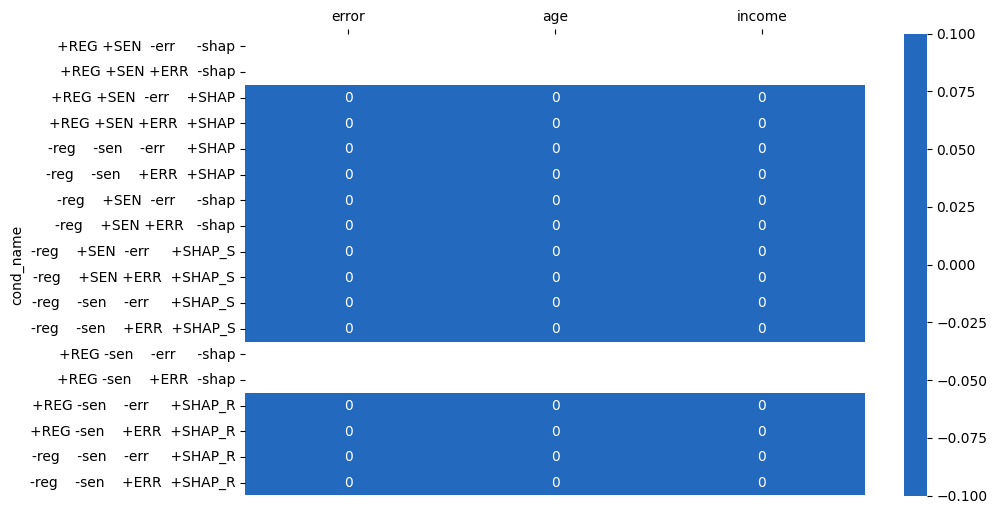

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### All Quality Metrics TNFP data

In [ ]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

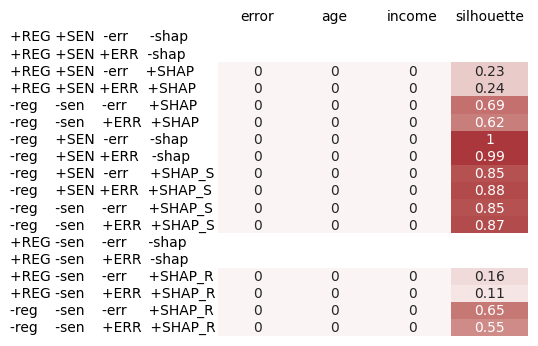

In [ ]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TNFP_Kproto.png', bbox_inches='tight', pad_inches=0)
files.download('TNFP_Kproto.png')
plt.show()

# DETAILED TNFP RESULTS

## One-vs-All cluster comparison TNFP data

0


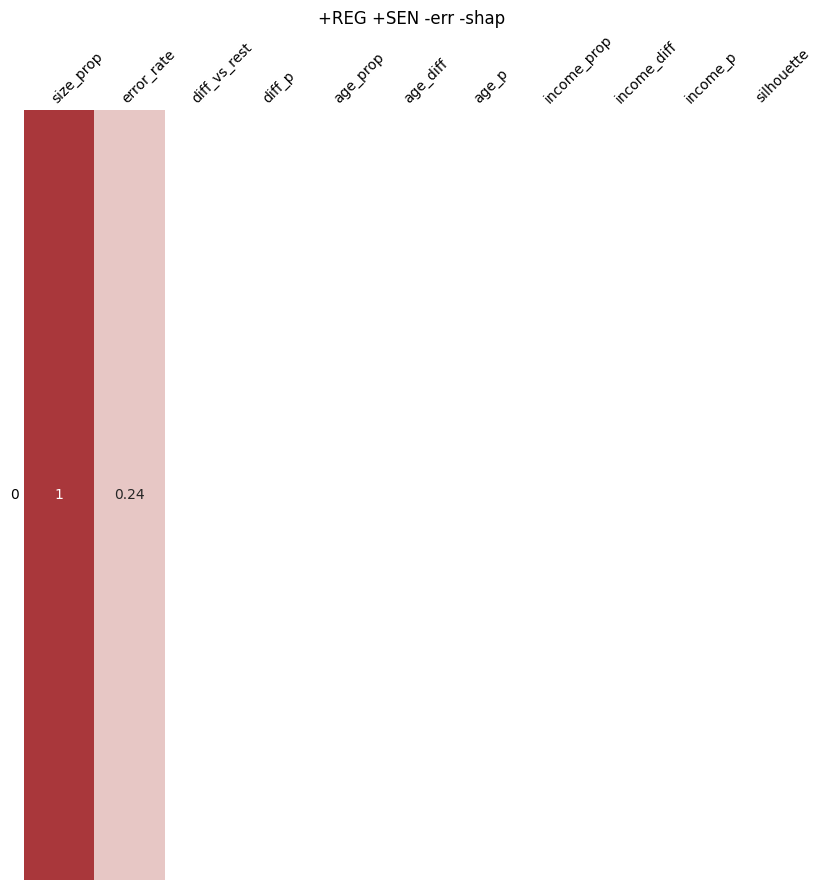

1


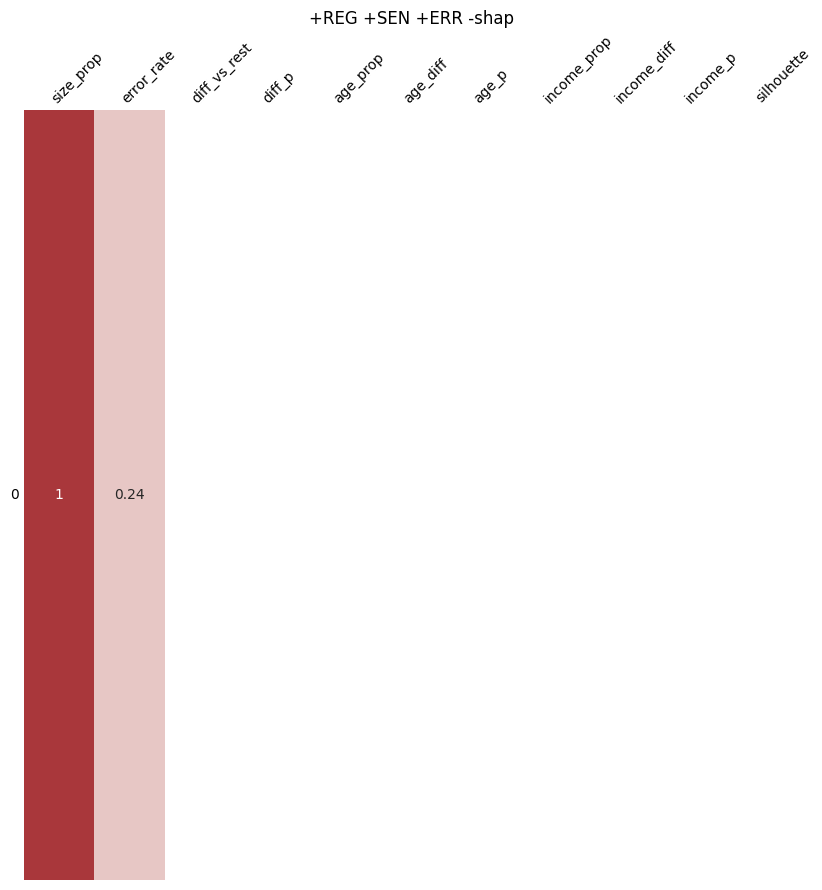

2


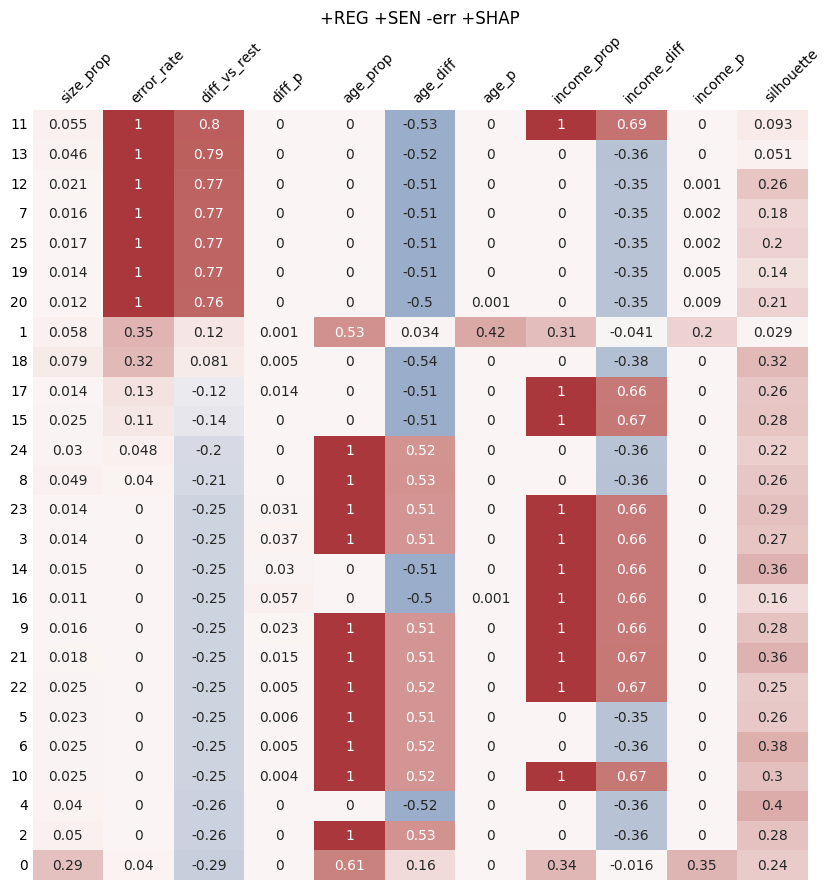

3


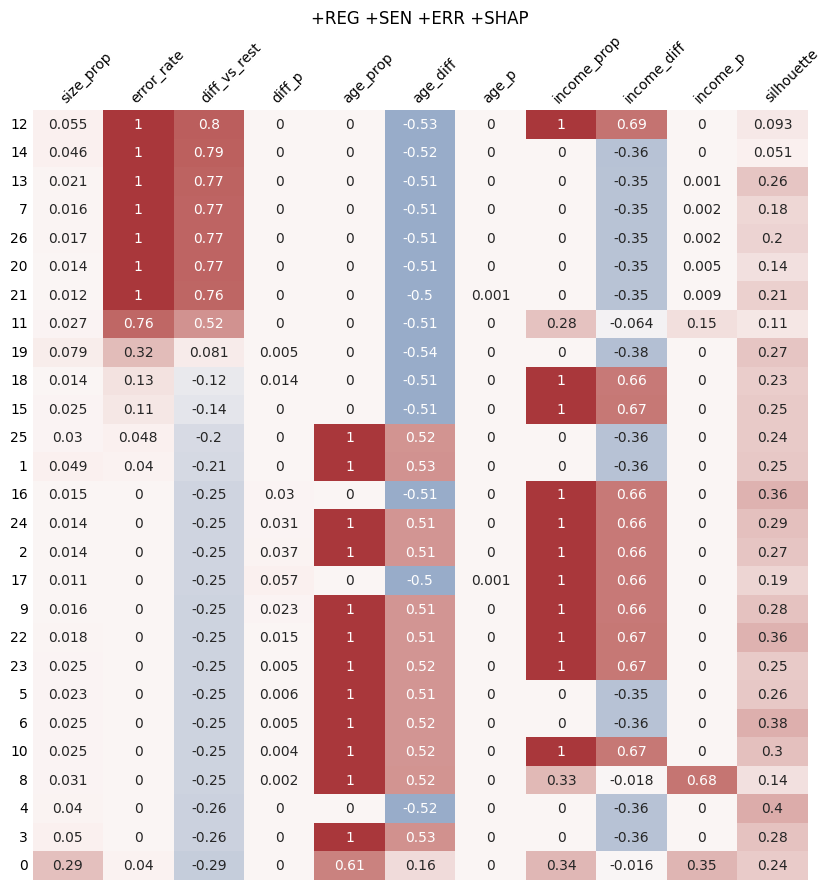

4


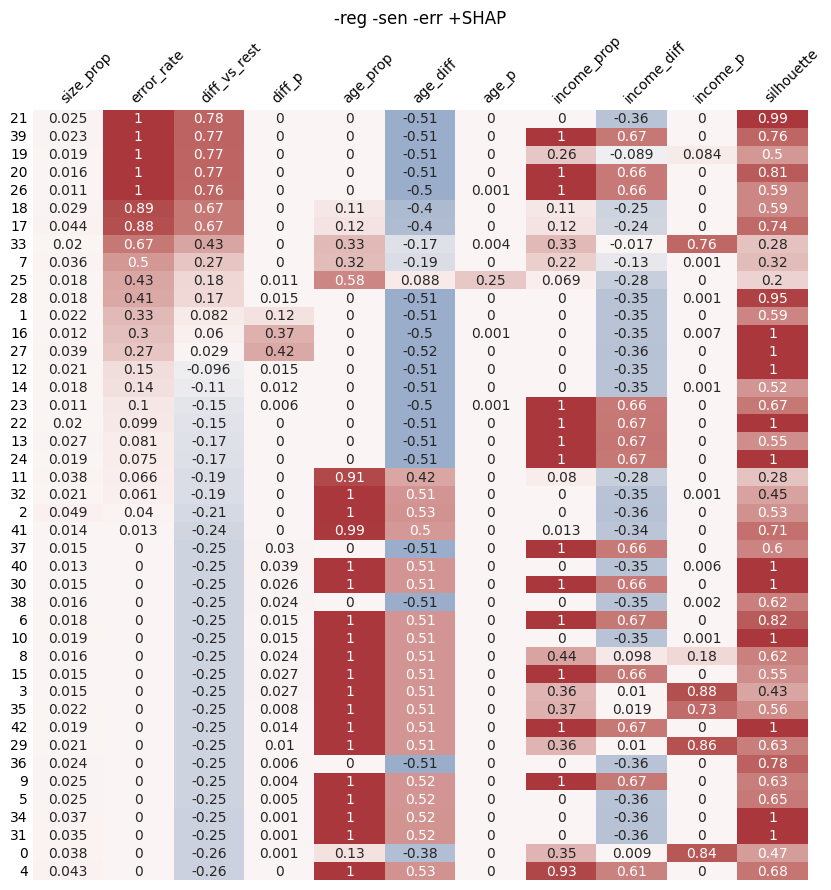

5


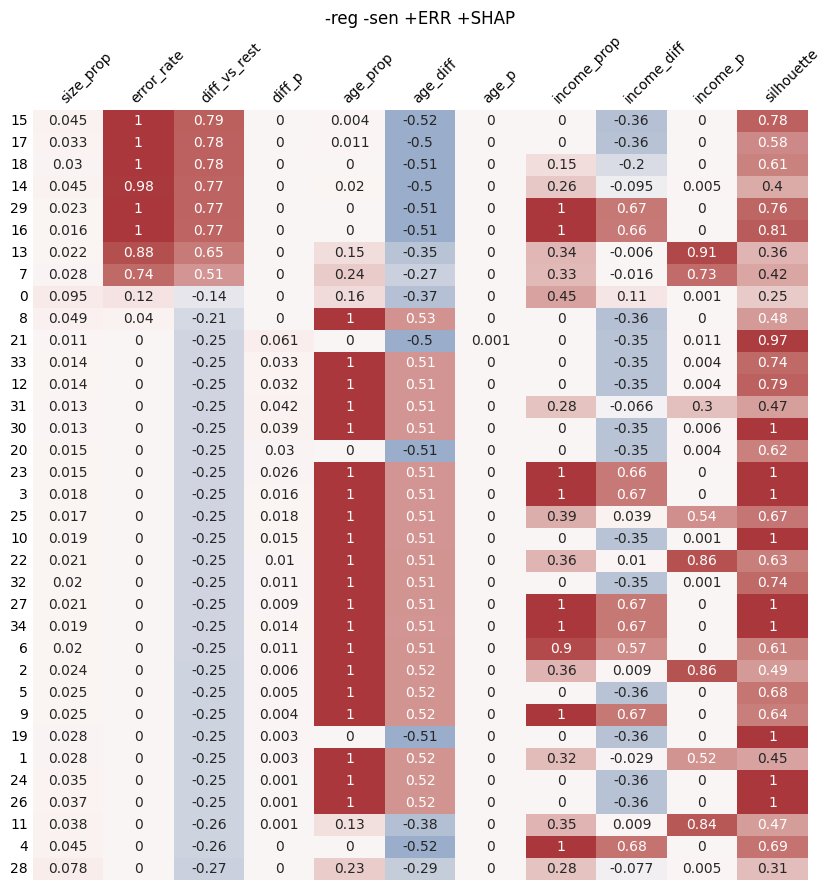

6


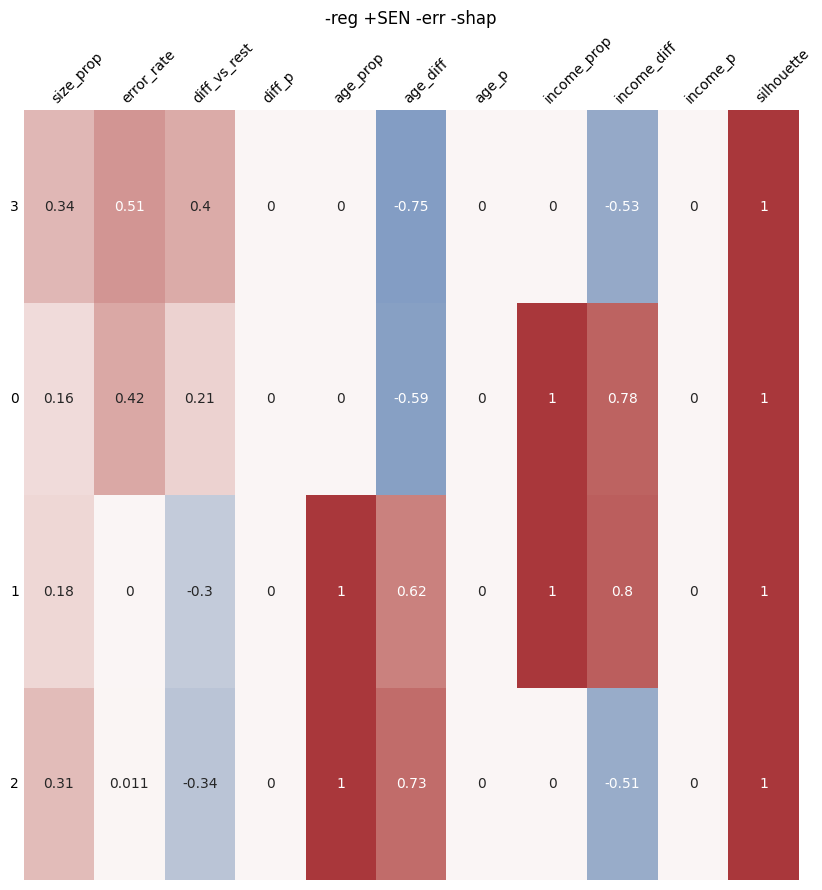

7


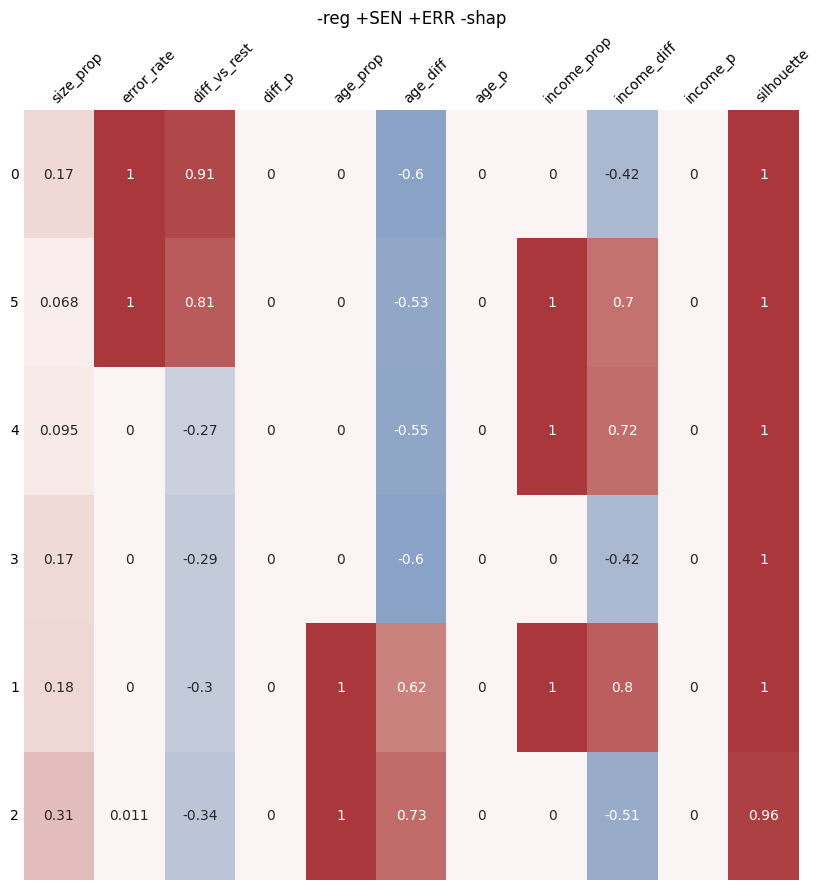

8


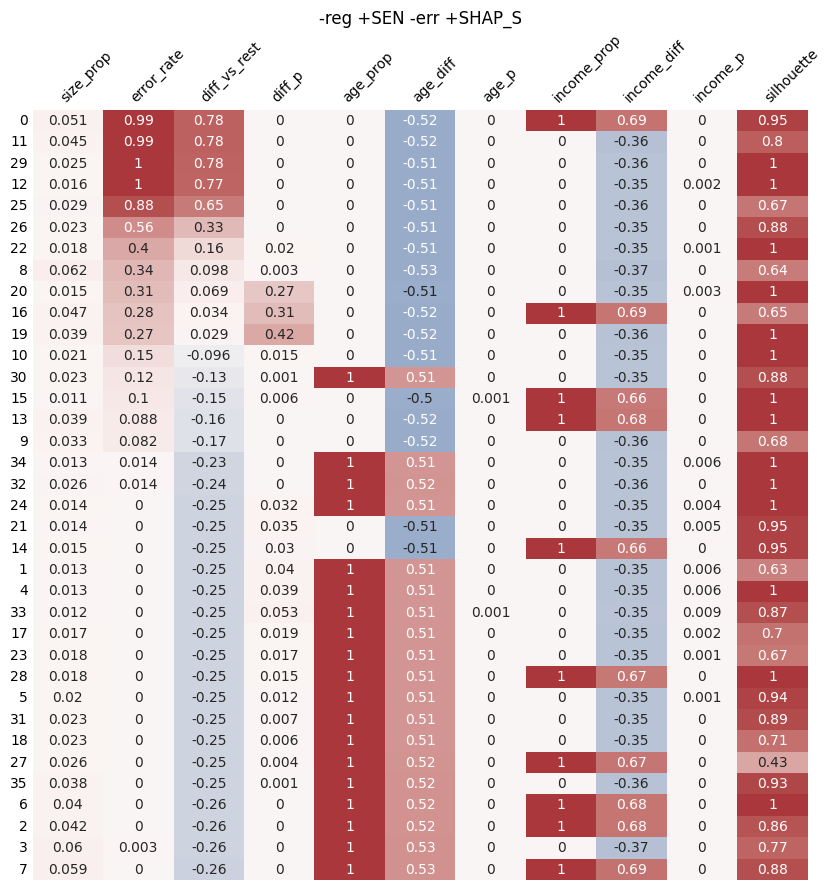

9


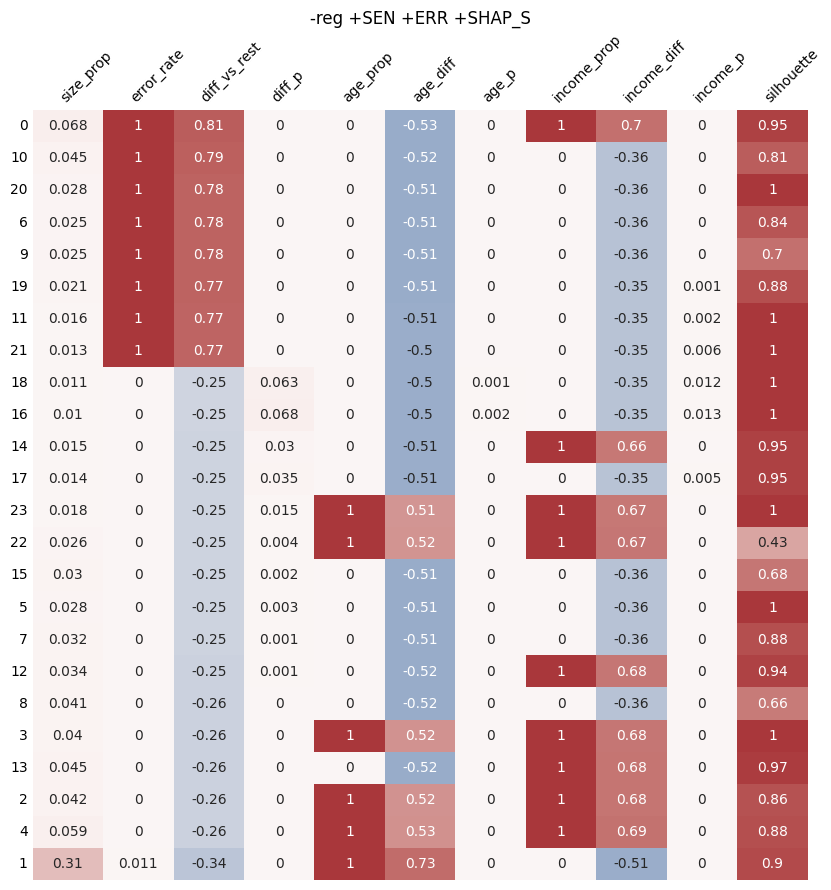

10


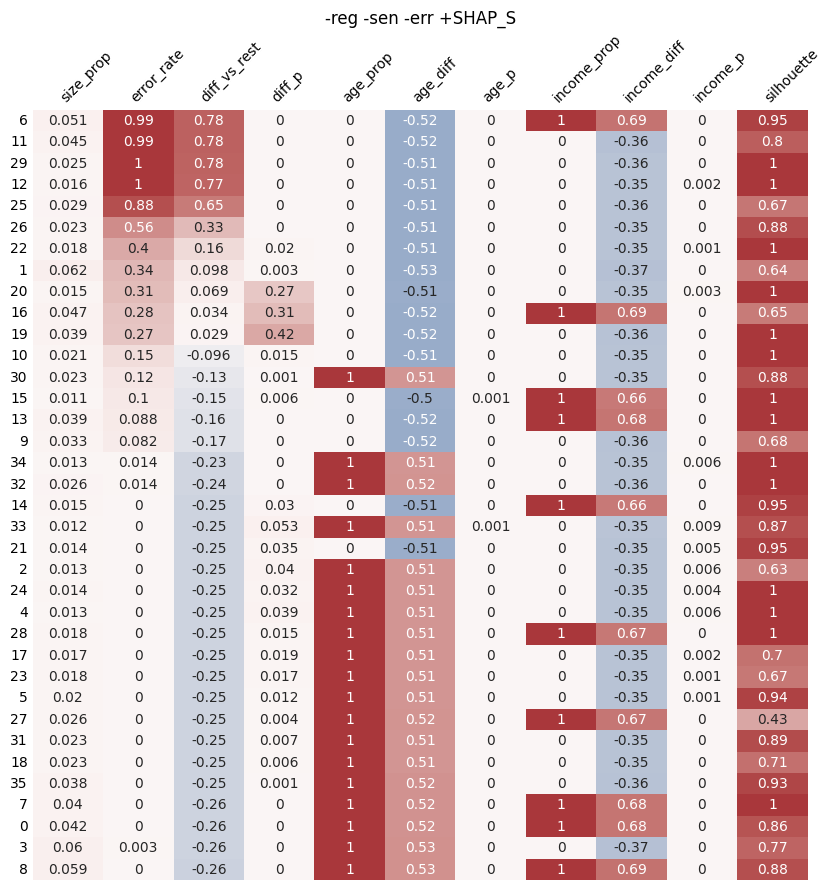

11


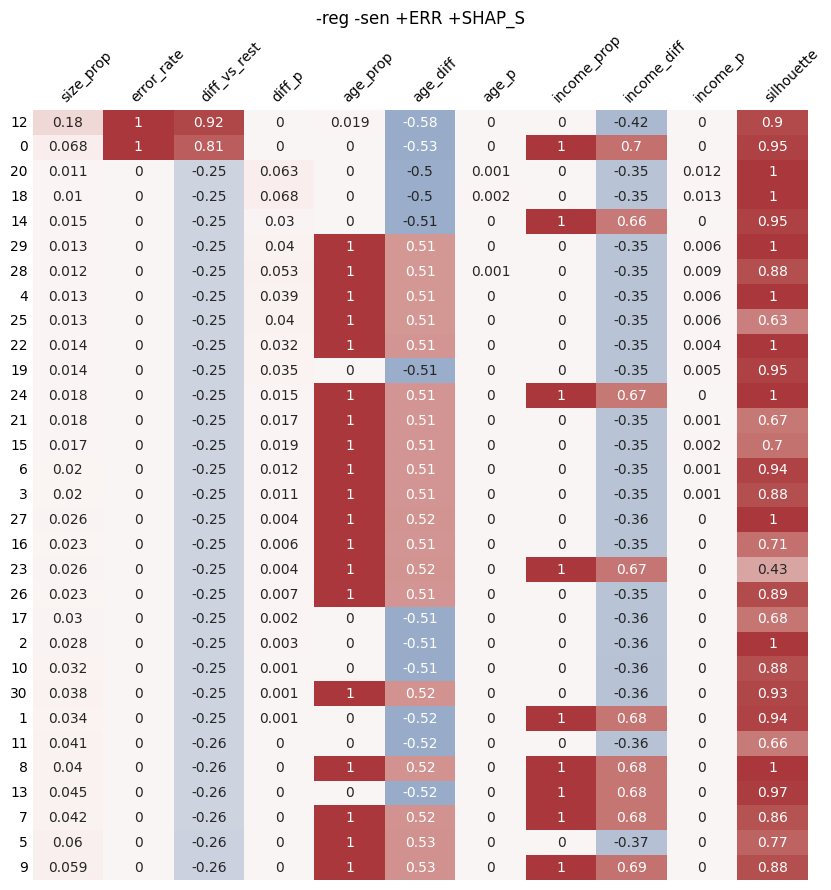

12


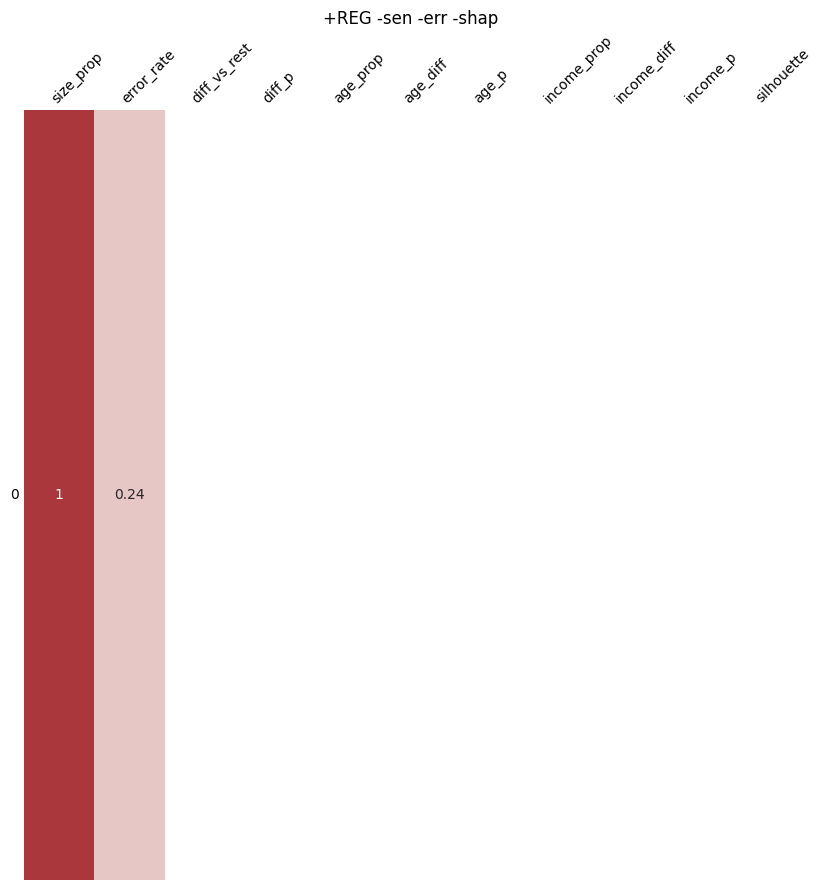

13


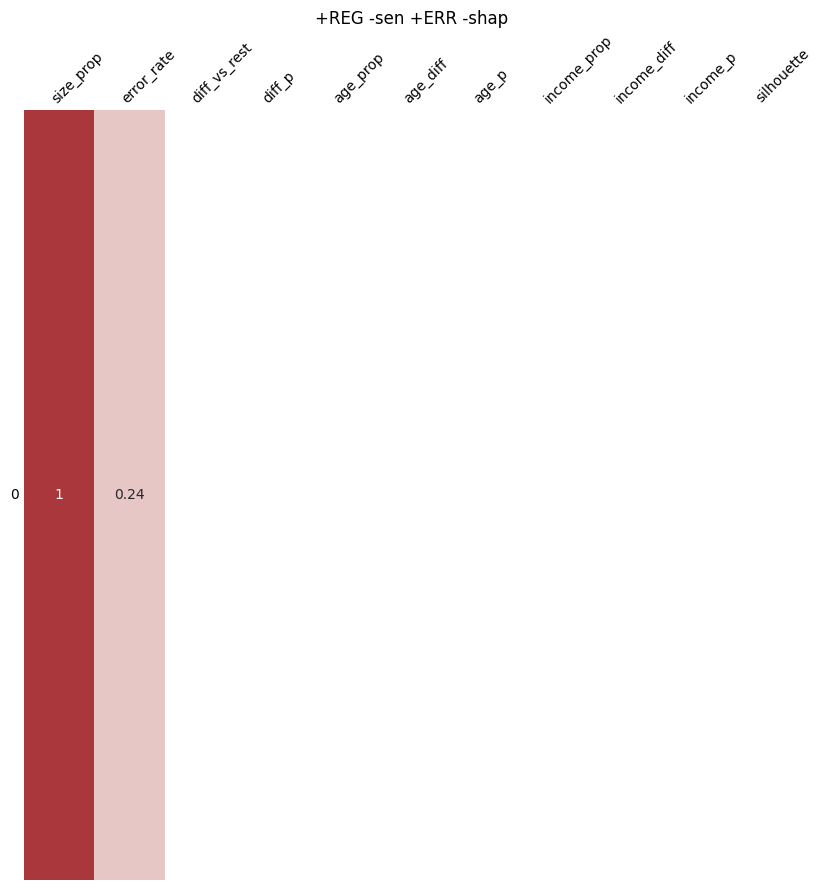

14


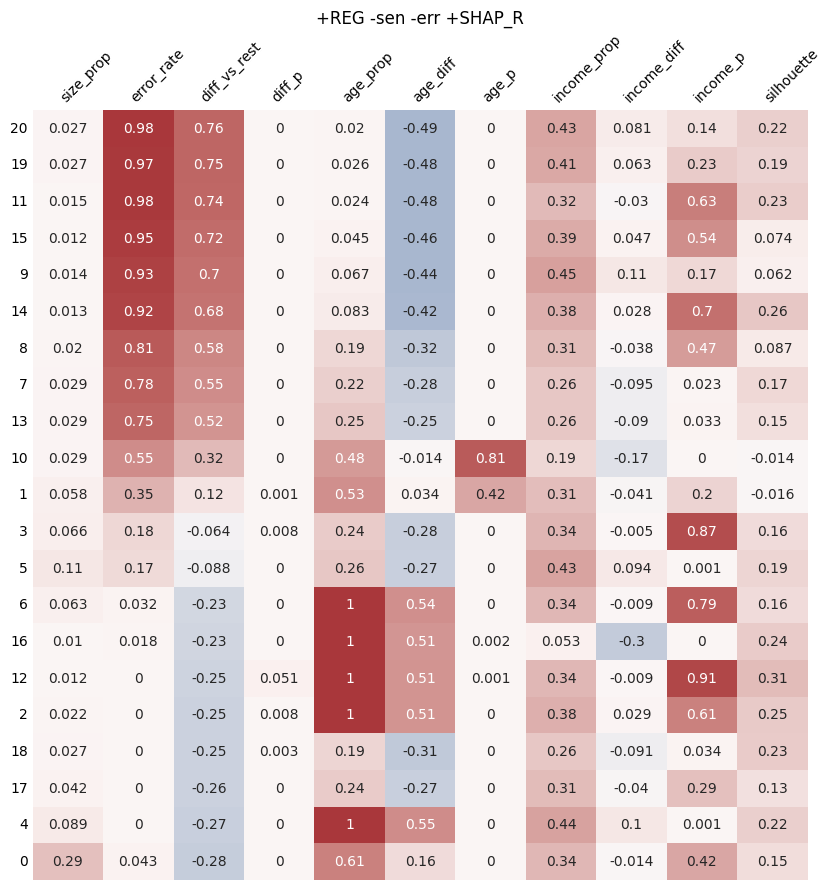

15


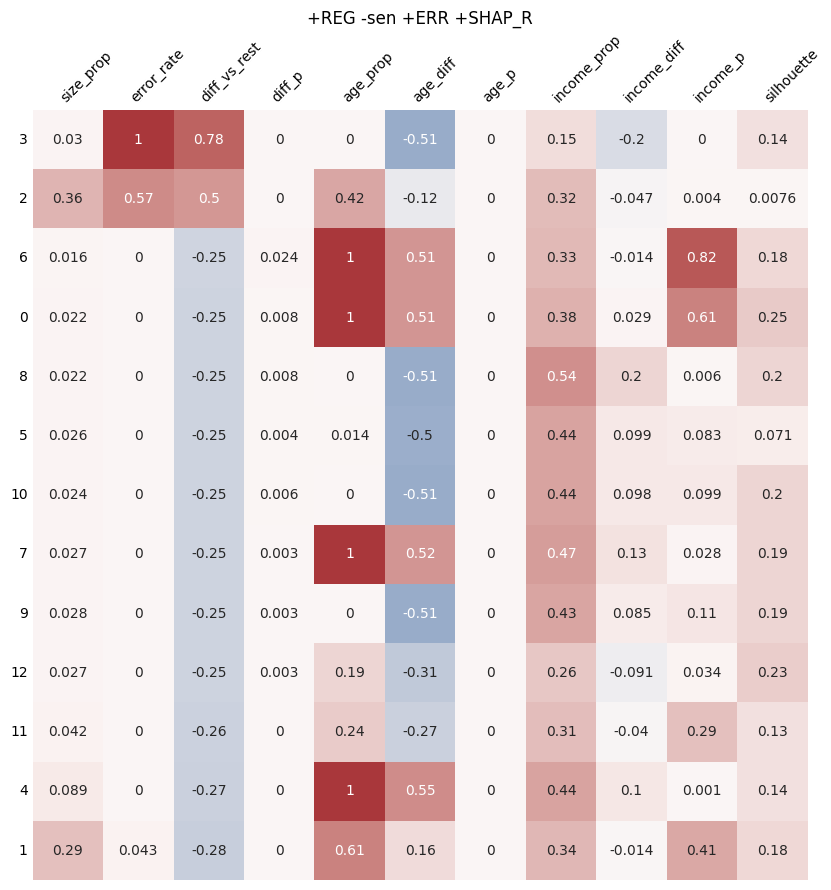

16


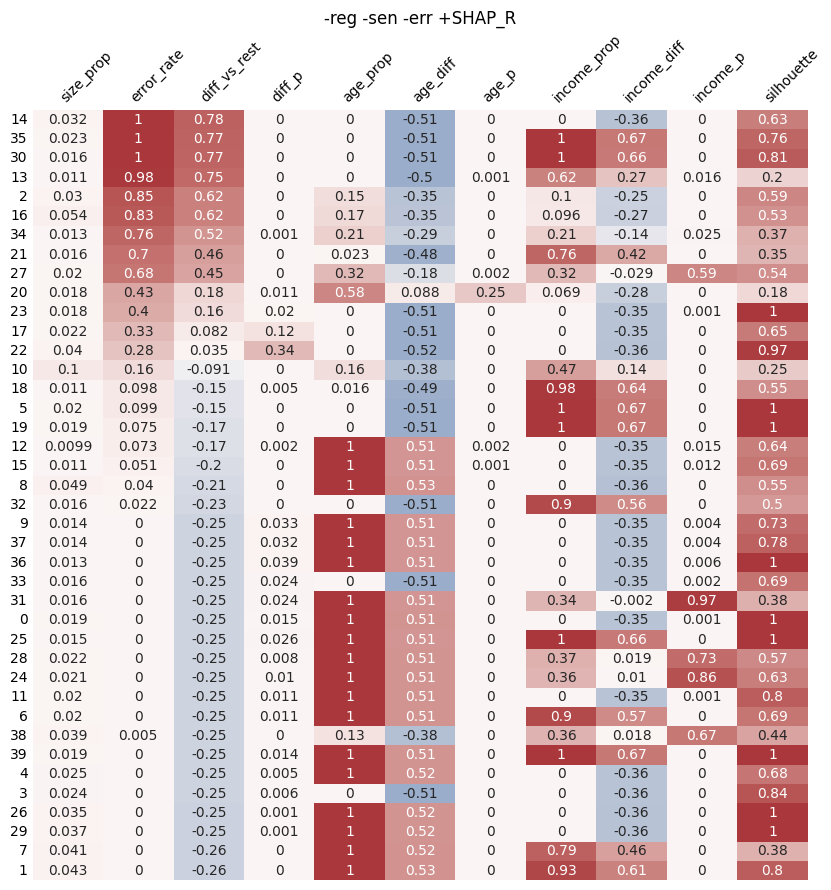

17


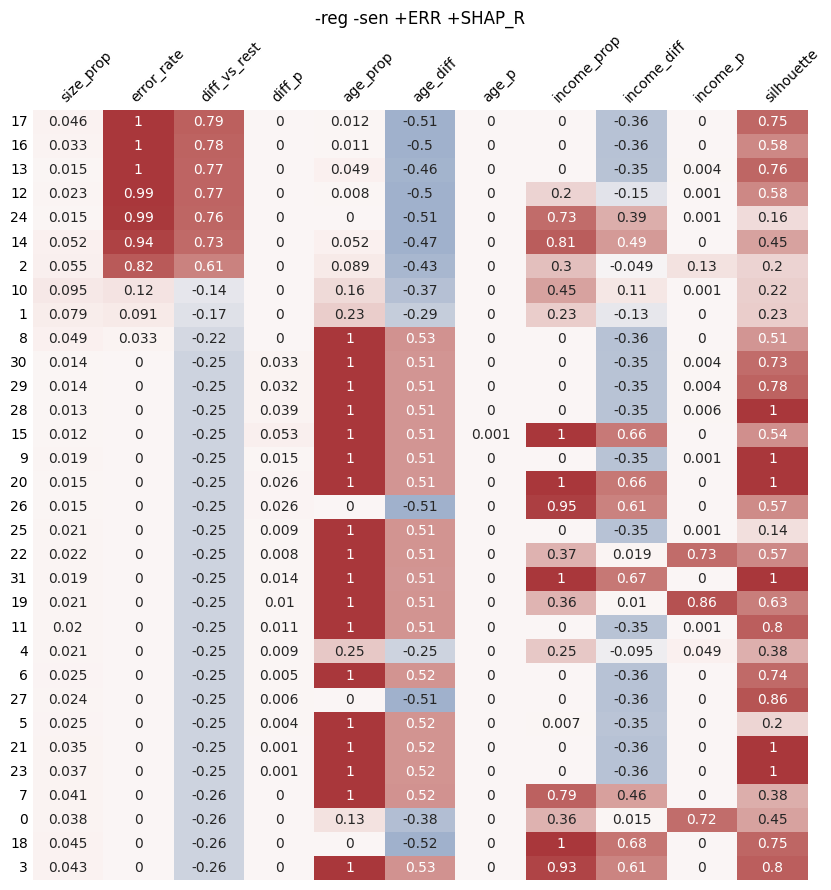

In [ ]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,10))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TNFP_Kproto_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

## t-SNE TNFP data

In [ ]:
'''#Create Error_Type for t-SNE
error_type = TNFP_data[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
TNFP_data['Error_Type'] = error_type.idxmax(axis=1).astype('category')'''

In [ ]:
'''for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = REG_scaled + DUMMY_scaled + SEN_scaled,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TNFP_Kproto_tSNE_')'''

ValueError: Could not interpret value `Error_Type` for `style`. An entry with this name does not appear in `data`.

<Figure size 1000x700 with 0 Axes>

# TPFN RESULTS

## Execute Experiments

In [ ]:
min_splittable_cluster_prop = 0.03
min_acceptable_cluster_prop = 0.01
min_acceptable_error_diff = 0.00

from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_proto(TPFN_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  exp_condition_name = re.sub(' +', ' ', exp_condition['feature_set_name'][i]),
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

+REG +SEN -err -shap
+REG +SEN +ERR -shap
+REG +SEN -err +SHAP
+REG +SEN +ERR +SHAP
-reg -sen -err +SHAP
-reg -sen +ERR +SHAP
-reg +SEN -err -shap
-reg +SEN +ERR -shap
-reg +SEN -err +SHAP_S
-reg +SEN +ERR +SHAP_S
-reg -sen -err +SHAP_S
-reg -sen +ERR +SHAP_S
+REG -sen -err -shap
+REG -sen +ERR -shap
+REG -sen -err +SHAP_R
+REG -sen +ERR +SHAP_R
-reg -sen -err +SHAP_R
-reg -sen +ERR +SHAP_R


##Chi-Square Tests TPFN data

In [ ]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

error   race_aa    race_c    gender
cond_name                                                               
+REG +SEN  -err     -shap         0.000000  0.000000  0.000000  0.074723
+REG +SEN +ERR  -shap             0.000000  0.000000  0.000000  0.100866
+REG +SEN  -err    +SHAP          0.000000  0.000000  0.000000  0.009259
+REG +SEN +ERR  +SHAP             0.000000  0.000000  0.000000  0.047769
-reg    -sen    -err     +SHAP    0.069151  0.767775  0.761914  0.778790
-reg    -sen    +ERR  +SHAP       0.043664  0.918876  0.681619  0.215522
-reg    +SEN  -err     -shap      0.000001  0.000000  0.000000  0.000000
-reg    +SEN +ERR   -shap         0.000250  0.000000  0.000000  0.221779
-reg    +SEN  -err     +SHAP_S         NaN       NaN       NaN       NaN
-reg    +SEN +ERR  +SHAP_S             NaN       NaN       NaN       NaN
-reg    -sen    -err     +SHAP_S  0.809710  0.576514  0.107850  0.384932
-reg    -sen    +ERR  +SHAP_S          NaN       NaN       NaN       NaN
+REG -sen    -err     -shap       0.000000  0.000000  0.000000  0.122866
+REG -sen    +ERR  -shap          0.000000  0.000000  0.000000  0.034922
+REG -sen    -err     +SHAP_R     0.000000  0.000000  0.000001  0.072475
+REG -sen    +ERR  +SHAP_R        0.000000  0.000000  0.000000  0.141823
-reg    -sen    -err     +SHAP_R  0.099527  0.377322  0.266374  0.286493
-reg    -sen    +ERR  +SHAP_R     0.000000  0.671966  0.180362  0.256411

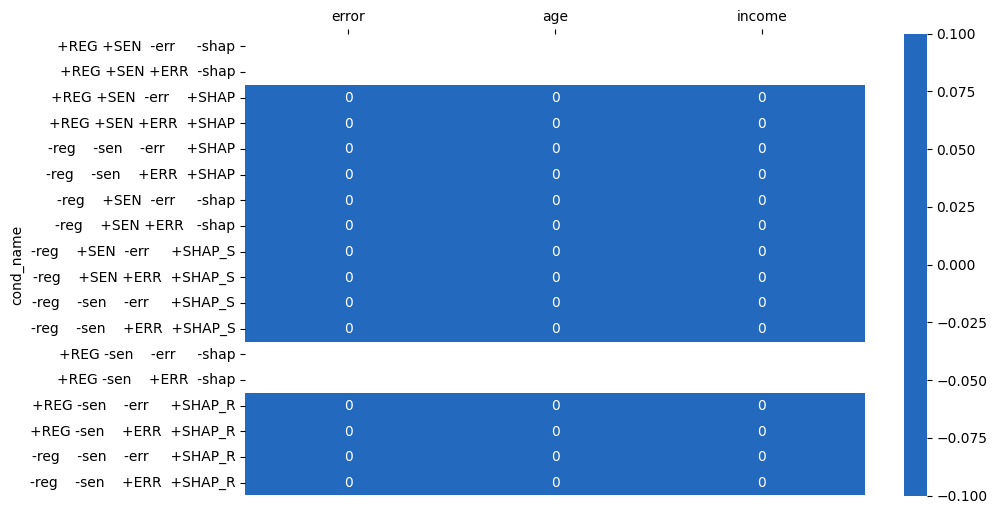

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

## All Quality Metrics TPFN data

In [ ]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

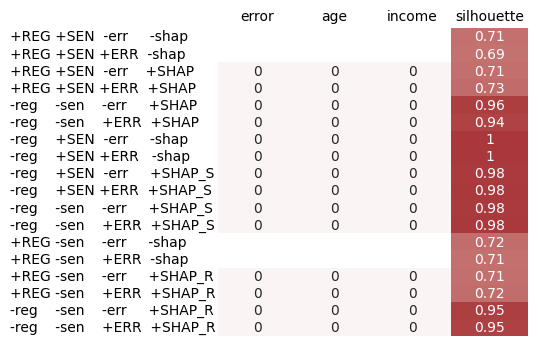

In [ ]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TPFN_Kproto.png', bbox_inches='tight', pad_inches=0)
files.download('TPFN_Kproto.png')
plt.show()

# DETAILED TPFN data


## One-vs-All cluster comparison TPFN data

0


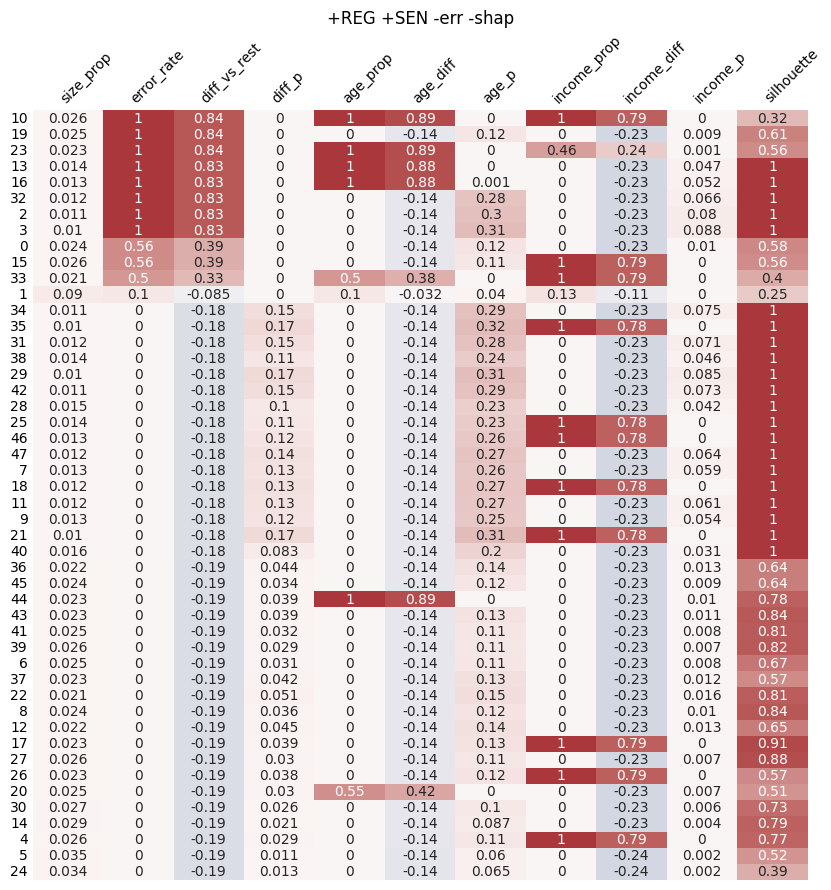

1


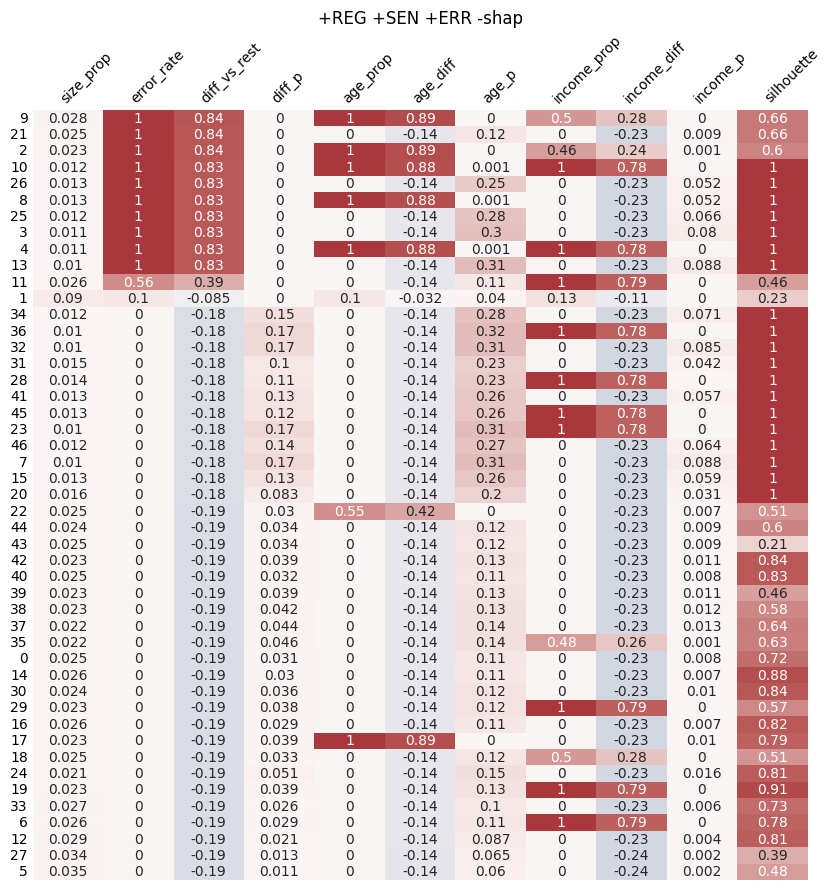

2


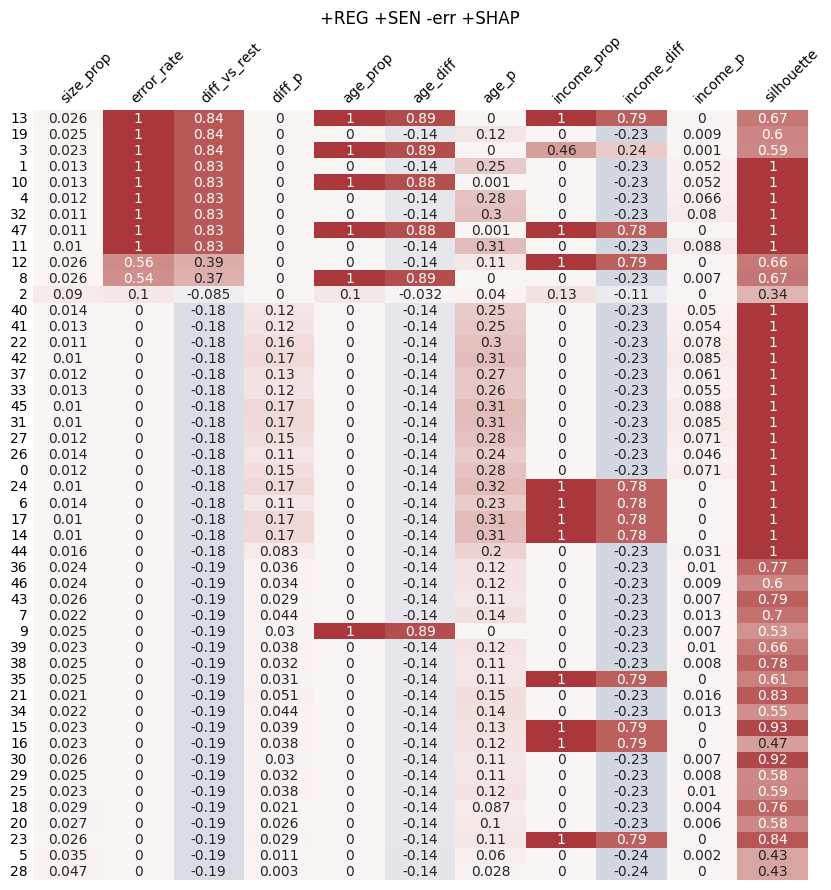

3


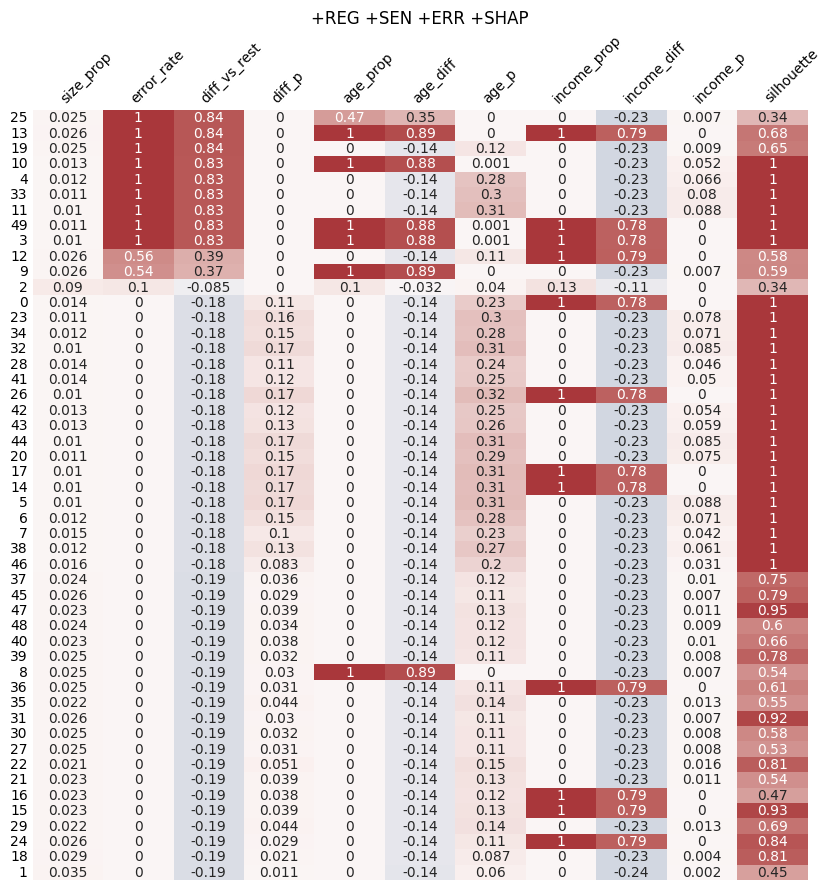

4


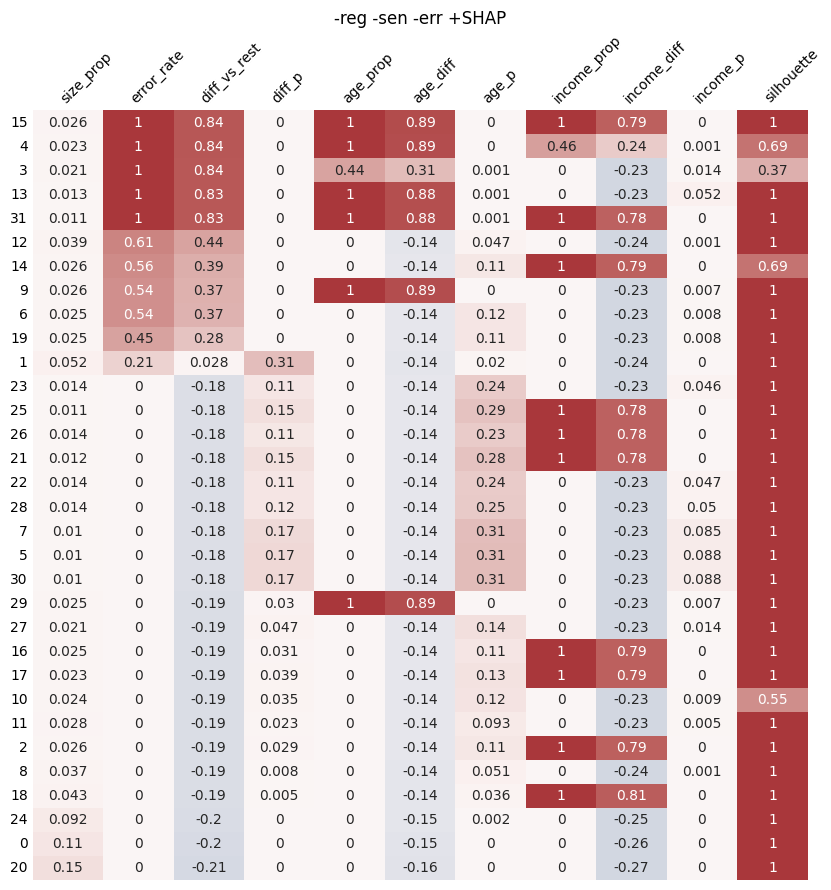

5


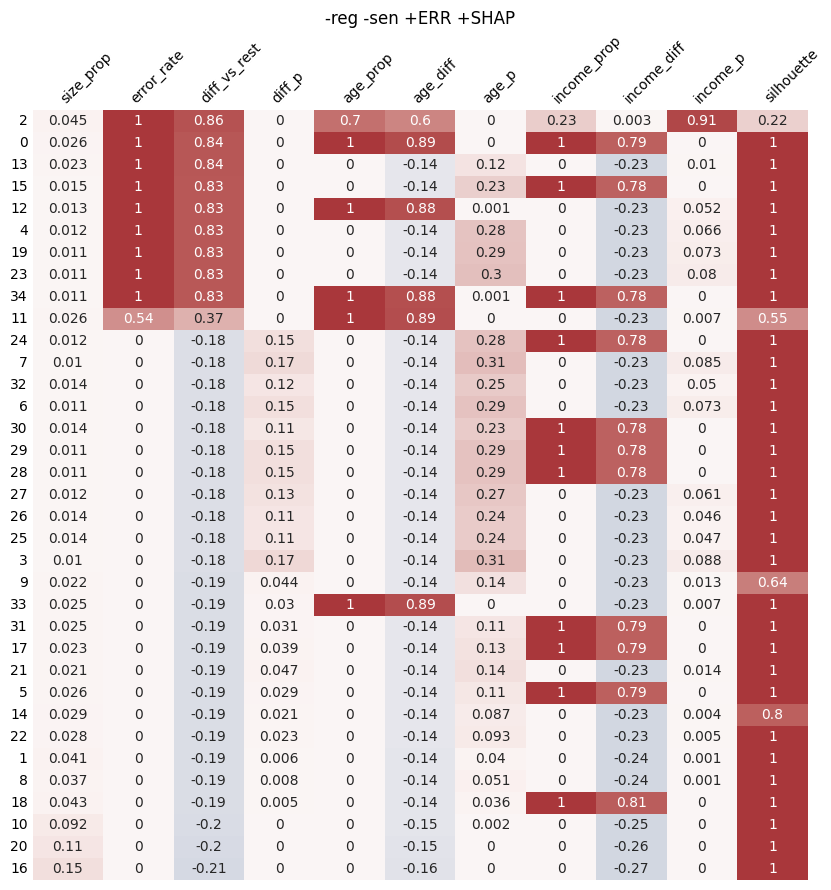

6


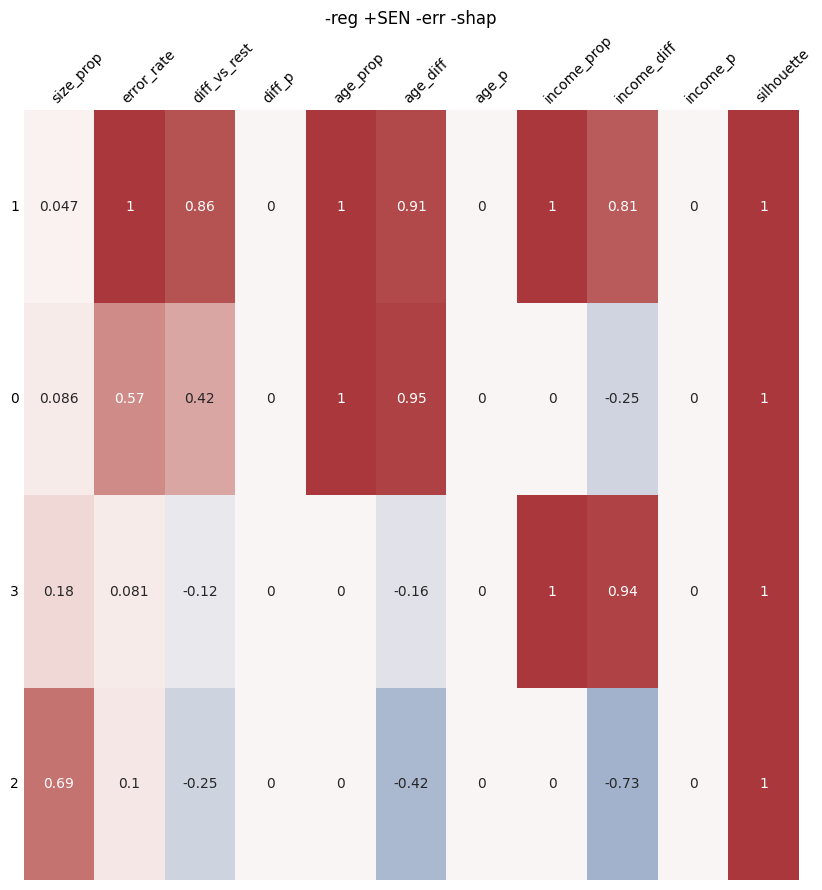

7


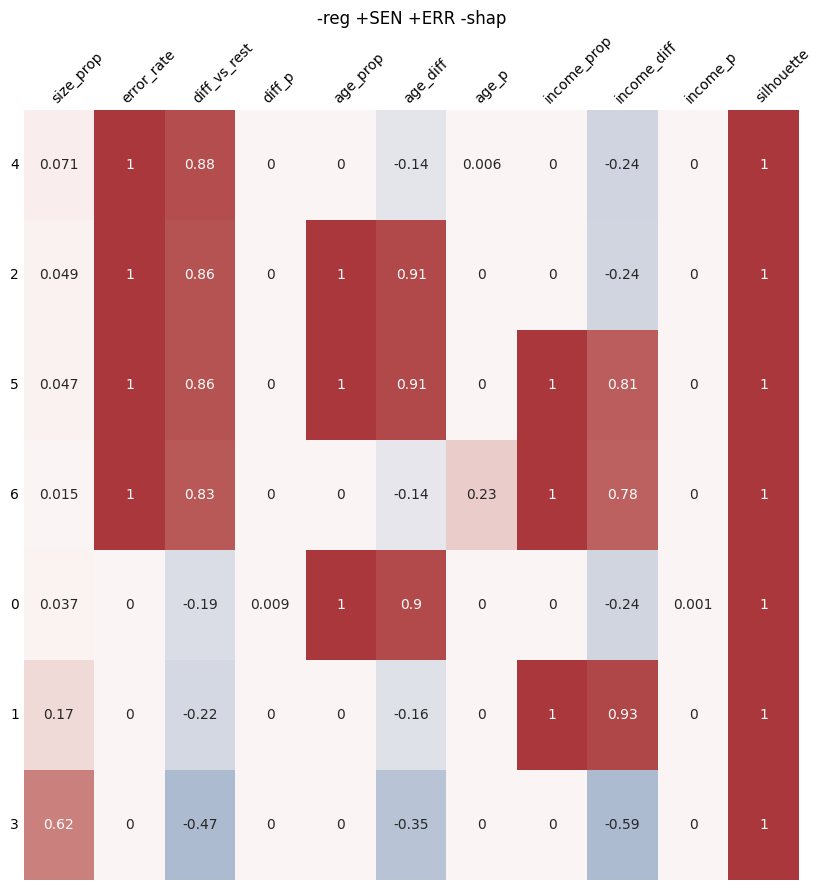

8


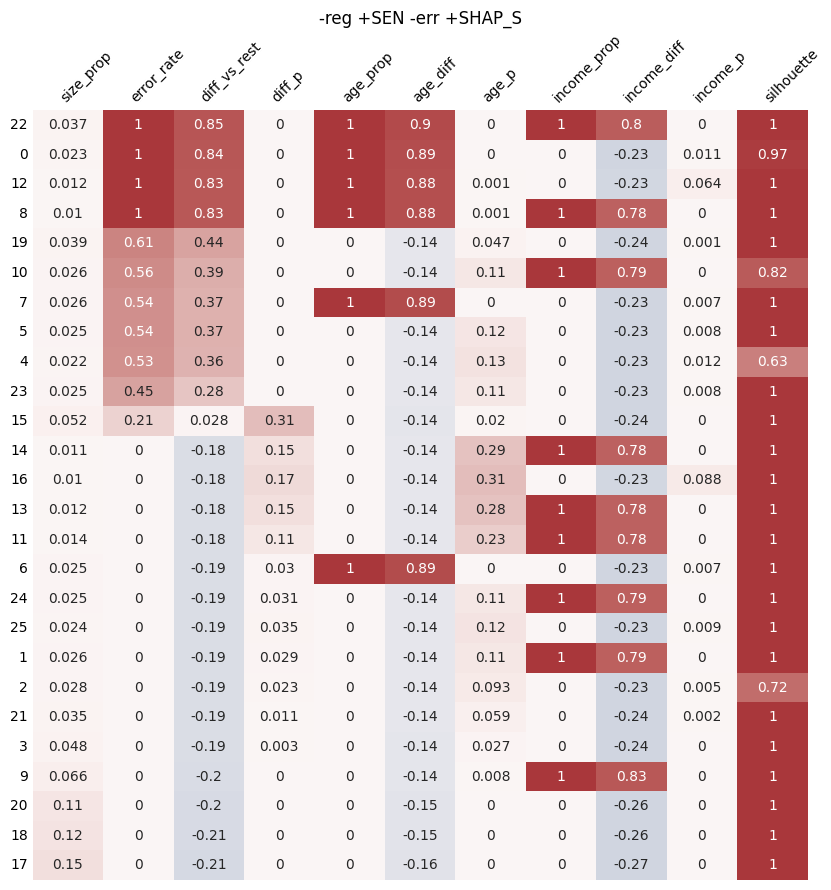

9


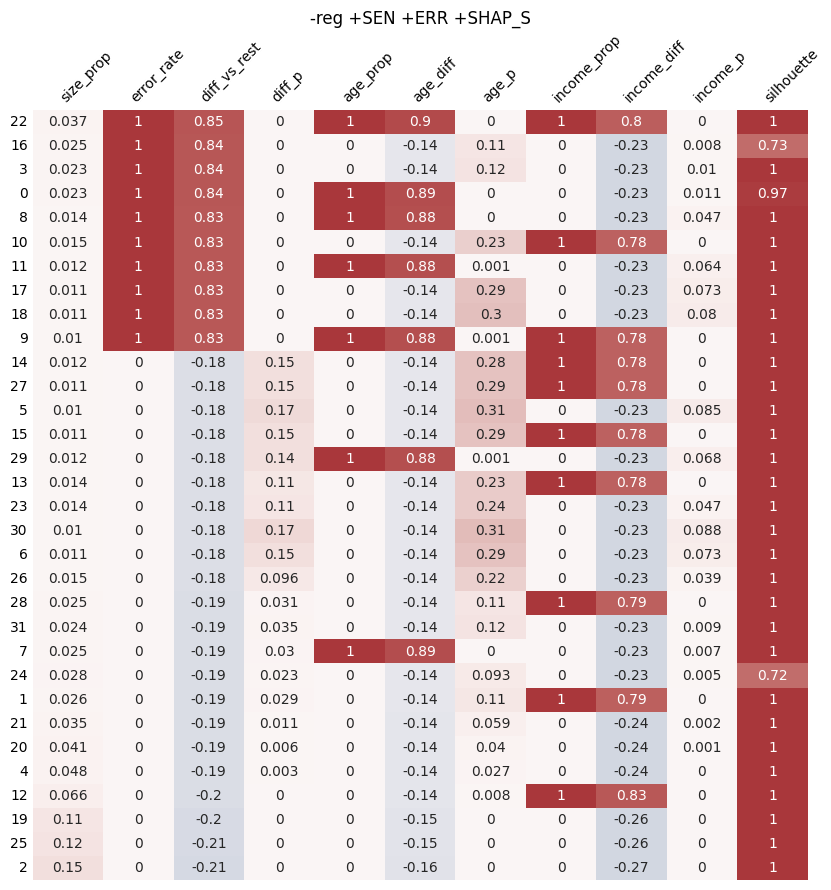

10


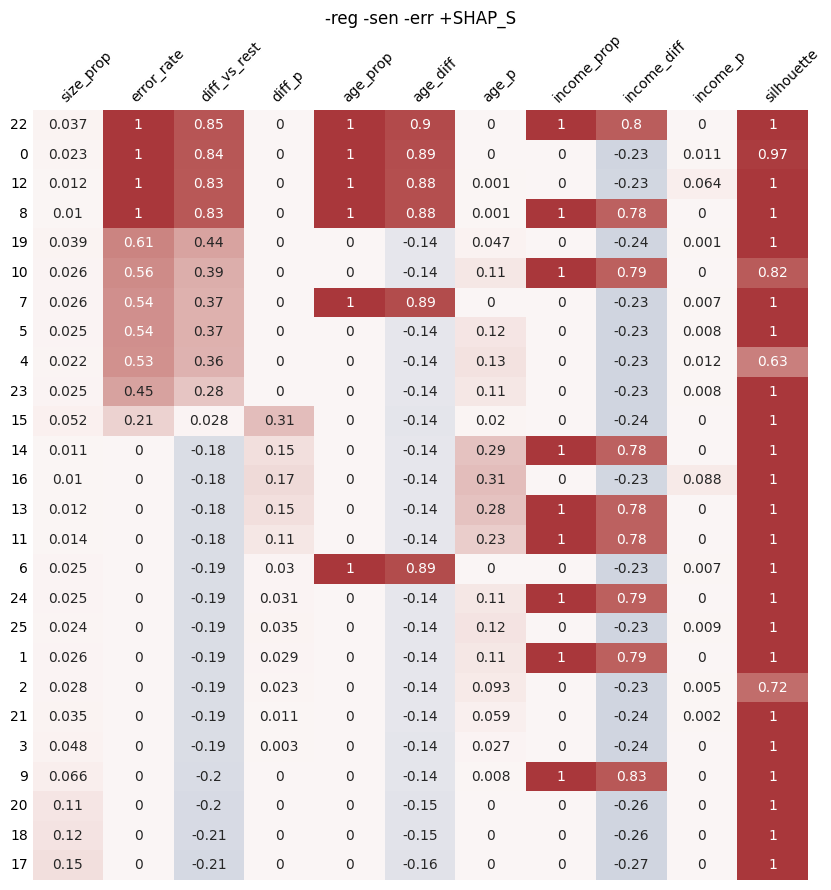

11


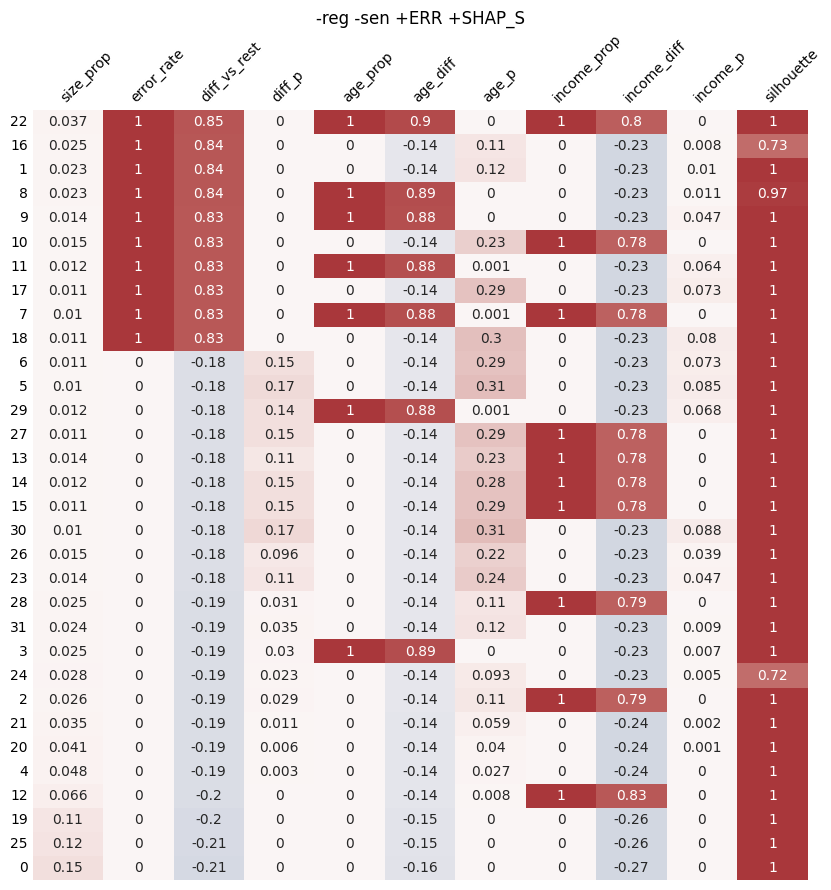

12


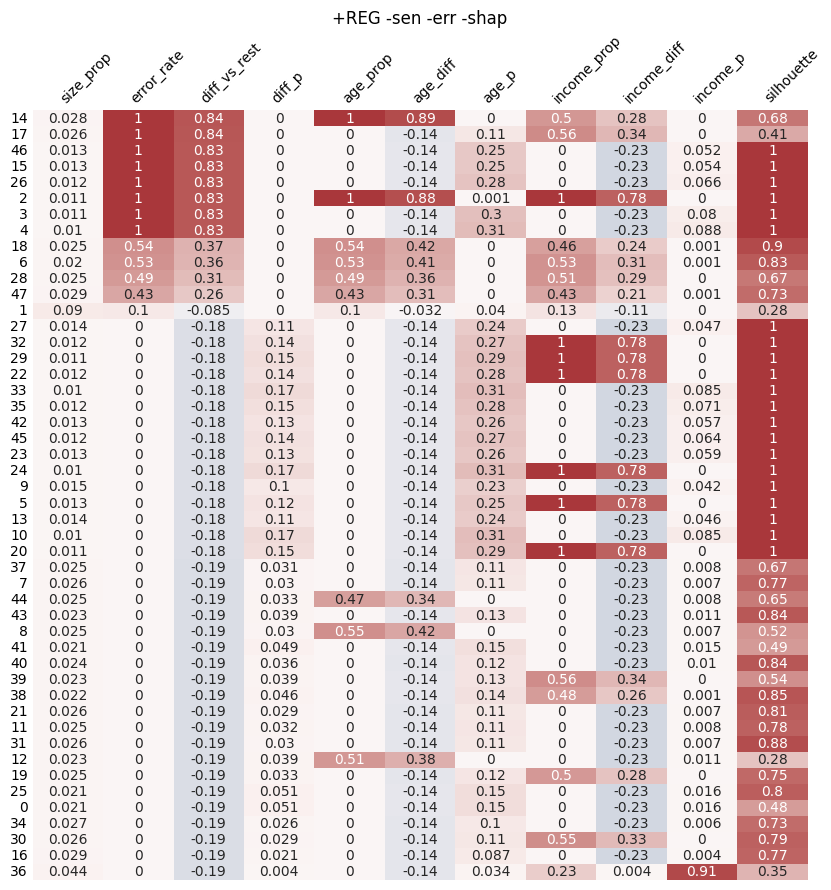

13


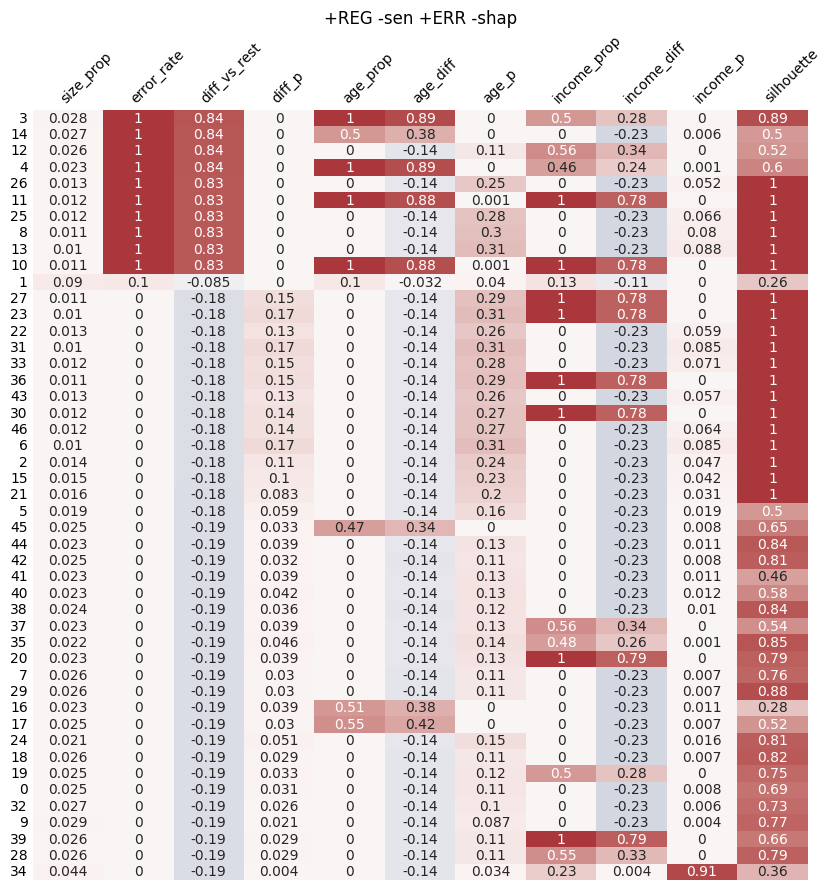

14


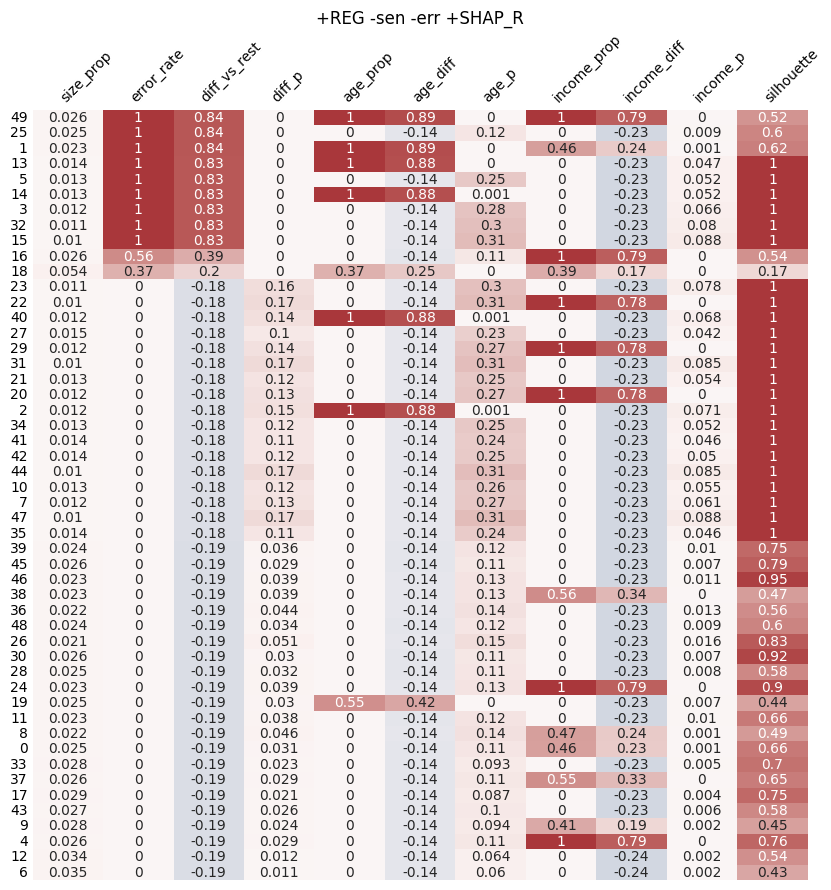

15


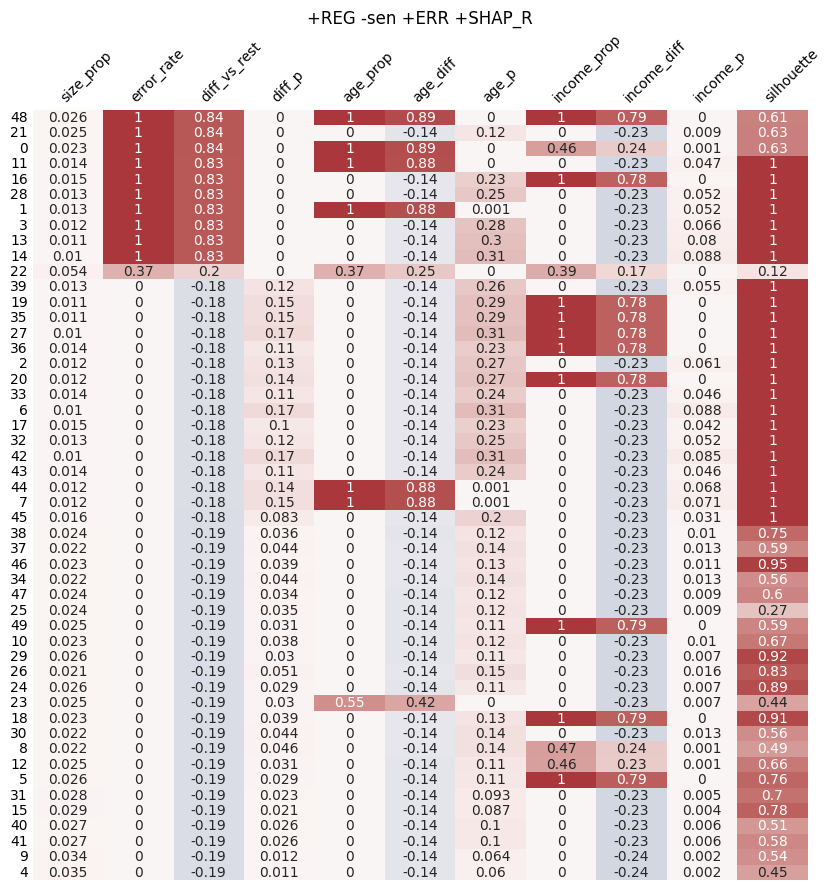

16


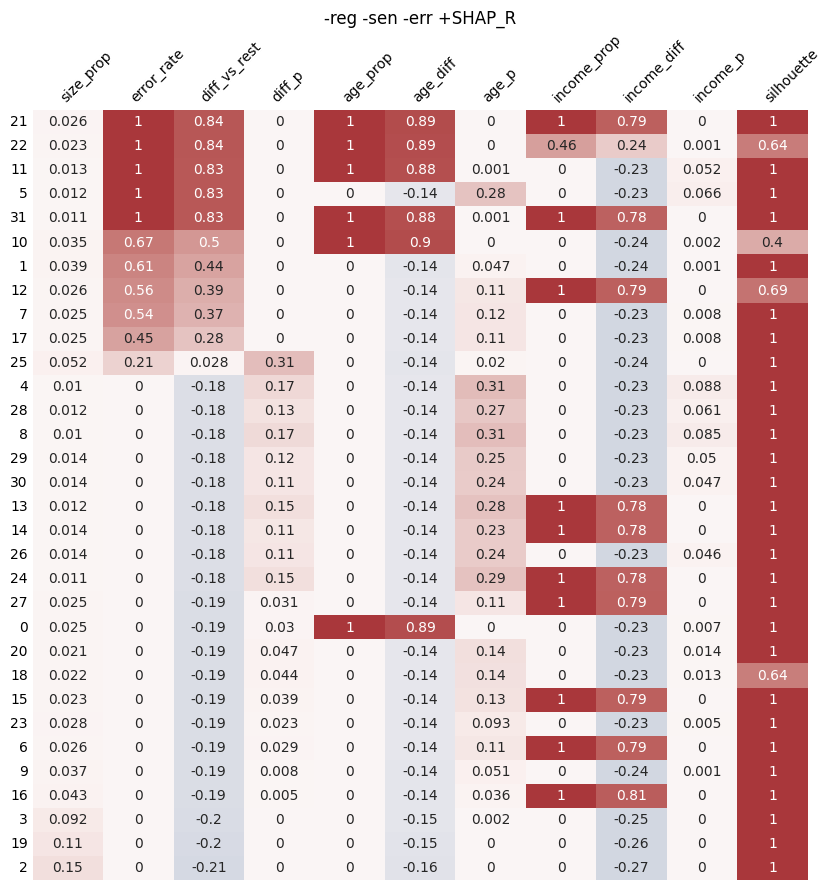

17


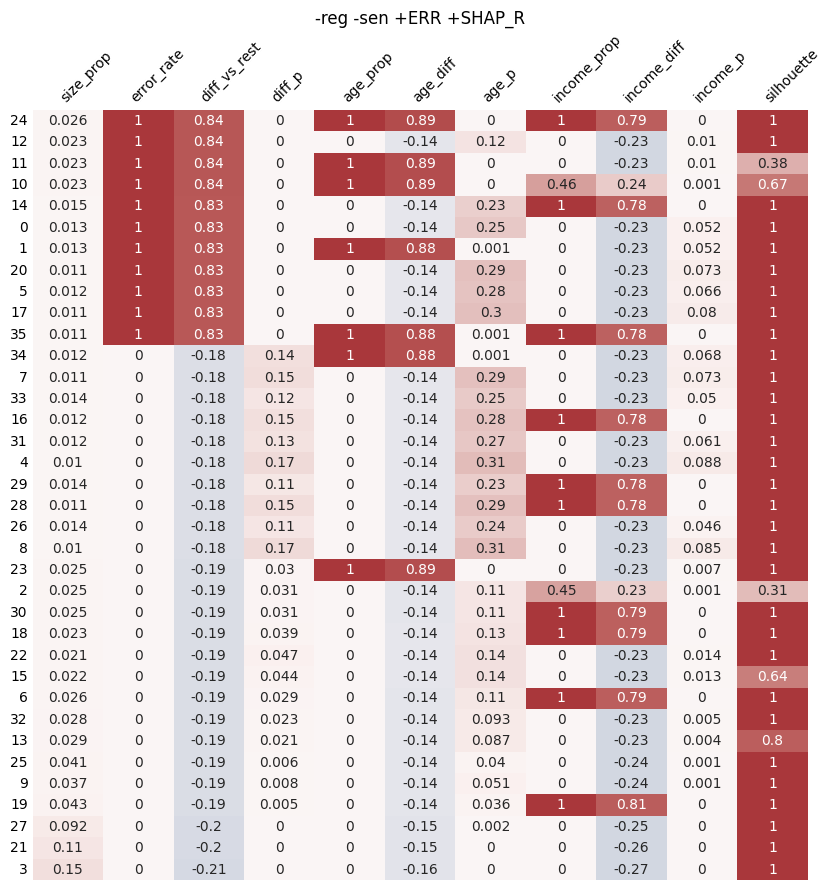

In [ ]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,10))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TPFN_Kproto_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

## t-SNE TPFN data

In [ ]:
'''for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TPFN_Kproto_tSNE_')'''

"for i in range(0, len(exp_condition)):\n  plt.figure(figsize=(10,7))\n  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),\n                      alpha = 0.7, size = 50,\n          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,\n          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TPFN_Kproto_tSNE_')"

# DOWNLOAD FIGURES

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TNFP_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(0, 9):\n  print(i)\n  files.download('TNFP_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TNFP_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(9, 18):\n  print(i)\n  files.download('TNFP_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TNFP_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(0, 9):\n  print(i)\n  files.download('TNFP_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TNFP_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(9, 18):\n  print(i)\n  files.download('TNFP_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TPFN_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(0, 9):\n  print(i)\n  files.download('TPFN_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TPFN_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(9, 18):\n  print(i)\n  files.download('TPFN_Kproto_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TPFN_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(0, 9):\n  print(i)\n  files.download('TPFN_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TPFN_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')'''

"for i in range(9, 18):\n  print(i)\n  files.download('TPFN_Kproto_tSNE_'+re.sub(' +', '', exp_condition['feature_set_name'][i])+'.png')"